### Imports 

In [1]:
import sys
import pymaid
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import seaborn as sns
from itertools import chain
import os
from tqdm import tqdm
from collections import Counter
import navis
from neuroboom import utils as nbu, dendrogram as nbd
import networkx as nx
import neuroboom
import seaborn as sns
from neuroboom import dendrogram as nbd
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy.stats import ks_2samp

In [2]:
os.getcwd()

'/Users/admin/Documents/LMB/Collaborations/Gruber'

In [3]:
# I've created a separate python file with my token credentials for security
# For this line of code to work, create a file called: token_credential_catmaid.py
# and in that file create a variable token = "abcdasa"
# replacing abcdasa with your catmaid token
from token_credential_catmaid import token as token

In [4]:
# Set CATMAID Instance
server = "https://catmaid.ice.mpg.de/catmaid_2020.02.15/#"
http_user = 'fly'
http_pw = 'superfly'
project_id = 6
# def connect_adult_em():
#     return pymaid.CatmaidInstance( server, http_user, http_pw, token)

def connect_adult_em():
    return pymaid.CatmaidInstance( server, token, http_user, http_pw, project_id = project_id)

connect_adult_em()

INFO  : Global CATMAID instance set. Caching is ON. (pymaid)


CatmaidInstance at 140512415169232.
Server: https://catmaid.ice.mpg.de/catmaid_2020.02.15/#
Project: 6
Caching True (size limit 128; time limit None)
Cache size: 0.0

# Dendrogram of DL5 uPN with OSN and LN input visualised

* PN#1
* PN#2 ...

* OSN#1
* OSN#2...

* MGN#1
* MGN#2...

In [5]:
# annotation 'Lydia 4' = DL5 uPN in project 6
# annotation 'Dami 9' = DA2 in project 2


n = pymaid.get_neurons(['PN#1'])
n

,
type,CatmaidNeuron
name,PN#1
id,355706
n_nodes,29741
n_connectors,4108
n_branches,2578
n_leafs,2635
cable_length,5078860.0
soma,None
units,1 nanometer


In [6]:
# converting the pymaid neuron into a navis neuron
navis_n = navis.TreeNeuron(n)
navis_n

,
type,navis.TreeNeuron
name,PN#1
id,355706
n_nodes,29741
n_connectors,4108
n_branches,2578
n_leafs,2635
cable_length,5078860.0
soma,"[116683, 245257, 118921, 138326, 139547, 11690..."
units,1 dimensionless


### Getting connector details

* creating a mapping between connectors and their presynaptic type
* upstream neurons need to be coloured by whether they are an OSN, LN or PN

* 6 colours: 3 for presyn, 3 for postsyn

In [7]:
pre_connectors = navis_n.connectors[navis_n.connectors.type == 0].connector_id.unique()
post_connectors = navis_n.connectors[navis_n.connectors.type == 1].connector_id.unique()

In [8]:
pre_con_details = pymaid.get_connector_details(pre_connectors)
post_con_details = pymaid.get_connector_details(post_connectors)

CN details:   0%|          | 0/545 [00:00<?, ?it/s]

INFO  : Data for 545 of 545 unique connector IDs retrieved (pymaid)


CN details:   0%|          | 0/1971 [00:00<?, ?it/s]

INFO  : Data for 1971 of 1971 unique connector IDs retrieved (pymaid)


In [9]:
all_connectors = dict(zip(navis_n.connectors.node_id, navis_n.connectors.index))

In [10]:
pre_con_details.head()

,connector_id,presynaptic_to,postsynaptic_to,presynaptic_to_node,postsynaptic_to_node
0,83487,355706,"[87662, 151172, 140064, 233415, 238845, 365526...",83486,"[83494, 83492, 83495, 83490, 83488, 83491, 834..."
1,83728,355706,"[203594, 213643, 214560, 352156]",83729,"[83730, 83731, 83732, 83733]"
2,83739,355706,"[237362, 88083, 88088, 214560, 171885, 233415,...",83667,"[83759, 83752, 83753, 83740, 83763, 83754, 837..."
3,83772,355706,"[88155, 181985, 203594]",83773,"[83775, 83778, 83776]"
4,83785,355706,"[88192, 88207, 88212, 191107, 178291]",83786,"[83788, 83791, 83792, 83789, 83787]"


In [11]:
post_con_details.head()

,connector_id,presynaptic_to,postsynaptic_to,presynaptic_to_node,postsynaptic_to_node
0,67354,126961,"[278189, 249283, 355706, 188300, 188300, 18535...",122945,"[67355, 67357, 67351, 288241, 165332, 67358, 1..."
1,67361,252367,"[69801, 69816, 355706, 121097, 188300]",164857,"[67363, 67366, 67362, 67364, 165951]"
2,67546,266320,"[355706, 164859, 217202, 69801]",194168,"[67542, 194154, 194156, 194159]"
3,67550,112162,"[167153, 160172, 355706, 355706, 355706, 12109...",107319,"[67552, 67557, 67549, 67551, 67553, 117860, 24..."
4,67583,266320,"[145837, 355706, 146277, 252367]",194142,"[67586, 67533, 67587, 67584]"


In [12]:
presyn_neurons = [j for i, j in enumerate(post_con_details.presynaptic_to.unique()) if j is not None]

In [13]:
ann = pymaid.get_annotations(presyn_neurons)

In [14]:
LN = []
OSN = []
PN = []

for i, j in ann.items():
    
    if 'LN' in ann[i]:
        
        LN.append(int(i))
    
    elif 'OSN' in ann[i]:
        
        OSN.append(int(i))
        
all_usns = list(chain.from_iterable([LN, OSN]))

coloured_types = ['OSN','LN']

In [15]:
LN[:10]

[147103, 151172, 185354, 69772, 135742, 140064, 146277, 253565, 278189, 119785]

In [16]:
OSN[:10]

[113830,
 134815,
 145512,
 125241,
 113710,
 113539,
 131099,
 113676,
 124777,
 112025]

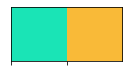

In [17]:
# What colours will we use?
sns.palplot(sns.color_palette('turbo', len(coloured_types)))

In [18]:
# creating a dictionary of skeleton_id to colour

pal = sns.color_palette('turbo', len(coloured_types))
type_to_col = dict(zip(coloured_types, pal))
osn_to_bid = dict(zip(OSN, [coloured_types[0]] * len(OSN)))
ln_to_bid =  dict(zip(LN, [coloured_types[1]] * len(LN)))
skid_to_type = {**osn_to_bid, **ln_to_bid}

In [19]:
# creating a dictionary where connector ids are mapped to the skeleton id of their presynaptic neuron
# defined in the cell above
connector_to_skid = {}

for i in all_usns:
    
    df = post_con_details[post_con_details.presynaptic_to == i].copy()
    
    temp_dict = dict(zip(df.connector_id.tolist(), df.presynaptic_to.tolist()))
    
    connector_to_skid.update(temp_dict)

In [20]:
# creating a dictionary where connector ids are mapped to the colour of their presynaptic neuron

cn_col = [ type_to_col[skid_to_type[connector_to_skid[i]]] for i, j in connector_to_skid.items()]
cn_ids = [i for i, j in connector_to_skid.items()]
connector_to_color = dict(zip(cn_ids, cn_col))

* if reusing the same dendrogram repeatedly, don't downsample the neuron

In [21]:
navis_n_prep = nbd.prepare_neuron_for_dendrogram(navis_n, heal_neuron= True, highlight_nodes=all_connectors,
                                                 downsample_neuron=1e6)

Healing neuron...
Downsampling neuron, factor = 1000000.0
Calculating cable length...
Converting connector types to strings...
Completed in 1s


In [22]:
g, pos = nbd.create_graph_structure(navis_n_prep, returned_object='graph_and_positions', 
                                    prog = 'dot', verbose=True)

Creating Graph Structure...
Calculating layout...
Returning graph and positions
Completed in 1386s


Plotting Tree...
Plotting soma
Plotting connectors...
Completed in 5s


<Figure size 432x288 with 0 Axes>

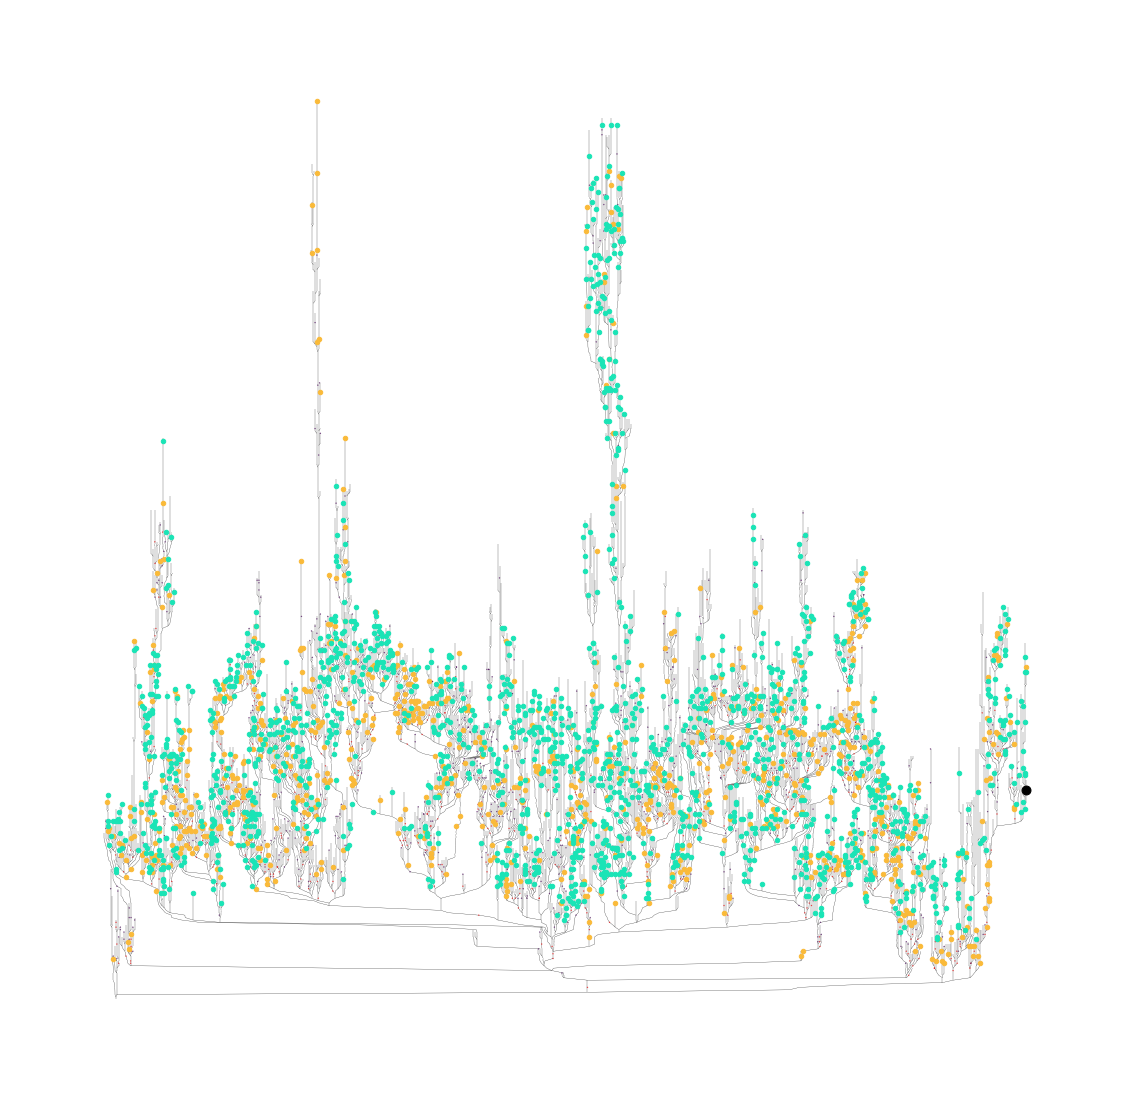

In [23]:
plt.clf()

fig, ax = plt.subplots(figsize = (20,20))

nbd.plot_dendrogram_from_graph(g, pos, 
                               navis_n_prep, 
                               highlight_connectors=connector_to_color)

plt.show()

In [24]:
# creating legend


legend_elements = []

for i in range(0, len(coloured_types)):
    
    
    legend_elements.append(Line2D([i], [0], marker = 'o', 
                                  color = type_to_col[coloured_types[i]],
                                  label = coloured_types[i], 
                                  markerfacecolor = type_to_col[coloured_types[i]],
                                  markersize = 60
                                 ))


<Figure size 432x288 with 0 Axes>

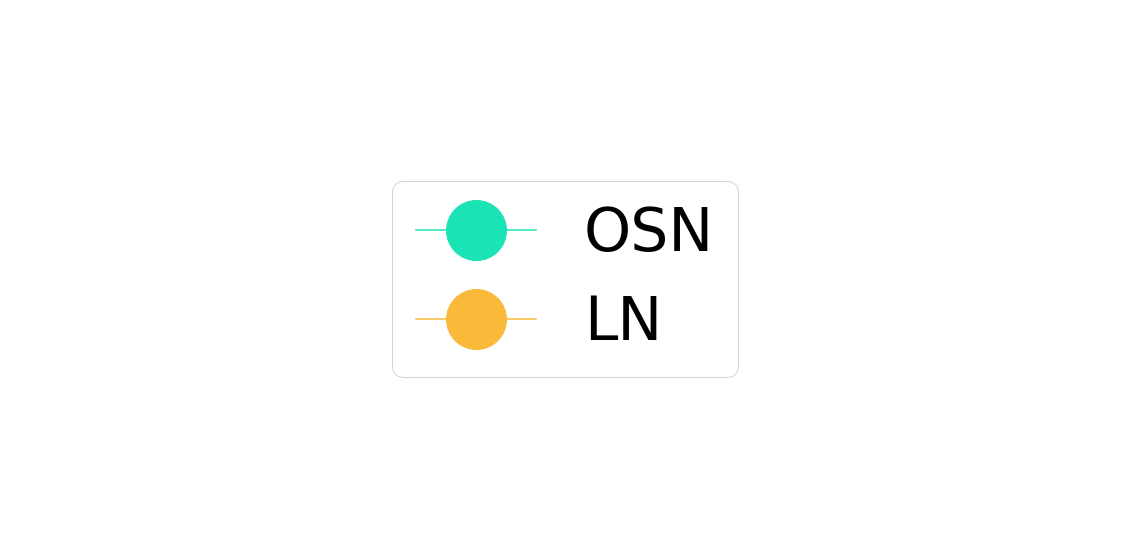

In [25]:
plt.clf()
fig, ax = plt.subplots(figsize = (20,10))

ax.legend(handles = legend_elements, loc= 'center', prop={'size':60})
plt.axis('off')
plt.show()
# plt.savefig(os.getcwd() + '/legend.png', dpi = 100)

# Visualising Autapses of DL5 uPN

In [26]:
# fetching the node table
node_table = pymaid.get_node_table(navis_n.id)

# removing na tags from the node table
node_table = node_table[~node_table.tags.isna()].copy()

INFO  : Retrieving 1 node table(s)... (pymaid)
INFO  : 29741 nodes retrieved. Creating table... (pymaid)


Creating table:   0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
autapses = node_table[['autapse' in i for i in node_table.tags.tolist()]].copy()

In [28]:
post_autapse_index = []

for i in range(len(autapses.tags.tolist())):
    
    tag_list = autapses.tags.tolist()[i]
    
    if any(['post' in j for j in tag_list]):
        
        post_autapse_index.append(i)
        
pre_autapse_index = []

for i in range(len(autapses.tags.tolist())):
    
    tag_list = autapses.tags.tolist()[i]
    
    if any(['pre' in j for j in tag_list]):
        
        pre_autapse_index.append(i)

In [29]:
autapse_pre_colors = dict(zip(autapses.iloc[pre_autapse_index, :].node_id.tolist(), 
                          [pal[0]] * len(autapses.iloc[pre_autapse_index, :].node_id.tolist())))

autapse_post_colors = dict(zip(autapses.iloc[post_autapse_index, :].node_id.tolist(), 
                               [pal[1]] * len(autapses.iloc[post_autapse_index, :].node_id.tolist())))

autapse_colors = {**autapse_pre_colors, **autapse_post_colors}
# autapse_colors

Plotting Tree...
Plotting soma


<Figure size 432x288 with 0 Axes>

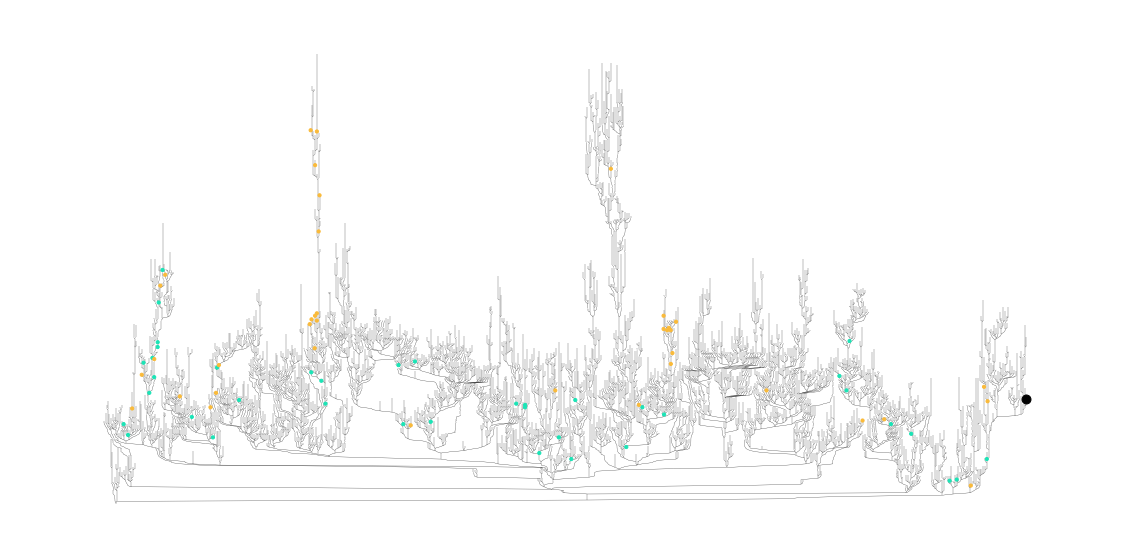

In [30]:
plt.clf()

fig, ax = plt.subplots(figsize = (20,10))

nbd.plot_dendrogram_from_graph(g, pos, navis_n_prep, highlight_nodes=autapse_colors, plot_connectors=False)

plt.show()

### Geodesic distances of the pre-autapse and post-autapse from the soma

In [31]:
# remove the last two columns (they're unnecessary at this stage)
autapses = autapses.iloc[:, :-2].copy()
autapses.head()

,node_id,parent_node_id,confidence,x,y,z,radius,creator,last_edited,skeleton_id
553,139346,161143,5,12910.070,8410.890,4580.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706
818,136900,319715,5,12213.313,8396.743,9840.0,4.0,dakinyemi,2022-03-29 10:06:51+00:00,355706
967,166337,289099,5,17850.176,10600.858,9100.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706
1077,170157,170155,5,22940.600,8502.036,12560.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706
2024,149733,287549,5,21232.080,6632.430,13300.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706


In [32]:
autapses['pre_autapse'] = 0
autapses['post_autapse'] = 0

for i in pre_autapse_index:
    
    autapses.iloc[i,-2] = 1
    
for i in post_autapse_index:
    
    autapses.iloc[i, -1] = 1

In [33]:
autapses.head()

,node_id,parent_node_id,confidence,x,y,z,radius,creator,last_edited,skeleton_id,pre_autapse,post_autapse
553,139346,161143,5,12910.070,8410.890,4580.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706,0,1
818,136900,319715,5,12213.313,8396.743,9840.0,4.0,dakinyemi,2022-03-29 10:06:51+00:00,355706,0,1
967,166337,289099,5,17850.176,10600.858,9100.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706,0,1
1077,170157,170155,5,22940.600,8502.036,12560.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706,1,0
2024,149733,287549,5,21232.080,6632.430,13300.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706,0,1


In [34]:
g_mat = navis.geodesic_matrix(navis_n)
# g_mat

In [35]:
pre_autapses = autapses[autapses.pre_autapse == 1].copy()
post_autapses = autapses[autapses.post_autapse == 1].copy()

In [36]:
g_mat_soma = g_mat[g_mat.index == navis_n.soma[0]].copy()

In [37]:
g_mat_soma = g_mat_soma.T.copy()
# g_mat_soma

In [38]:
pre_autapse_dist = g_mat_soma[np.isin(g_mat_soma.index, pre_autapses.node_id)].copy()

In [39]:
post_autapse_dist = g_mat_soma[np.isin(g_mat_soma.index, post_autapses.node_id)].copy()

In [40]:
pal = sns.color_palette('turbo', 2)
pal

[(0.10342, 0.896, 0.715), (0.98, 0.73, 0.22161)]

/Users/admin/opt/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<Figure size 432x288 with 0 Axes>

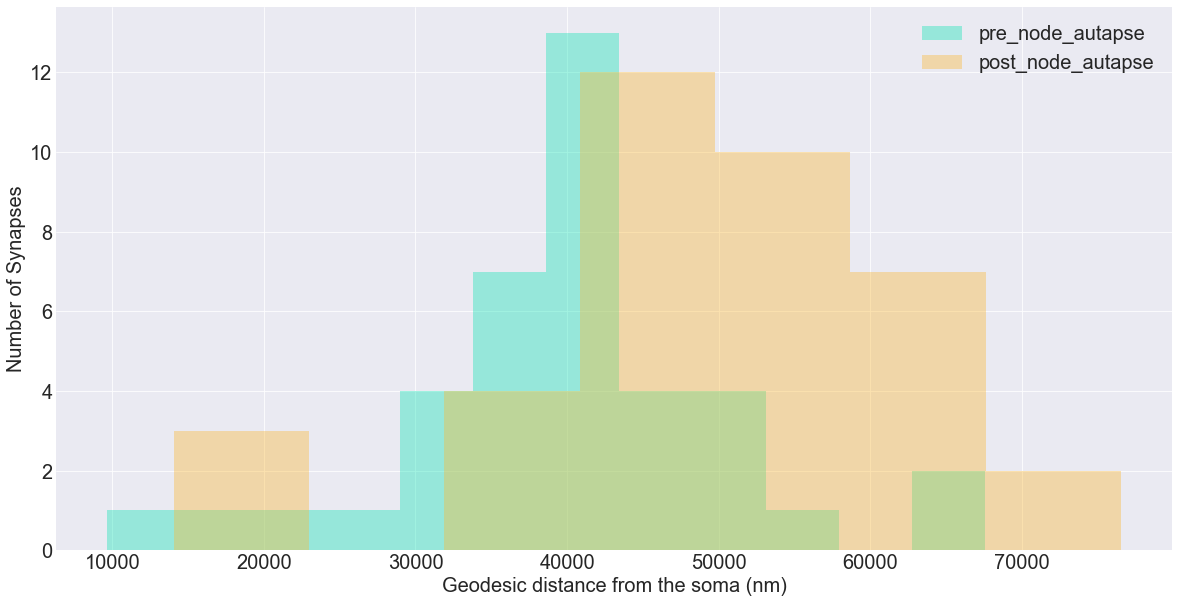

In [41]:
plt.style.use('seaborn-darkgrid')

plt.clf()

fig, ax = plt.subplots(figsize = (20,10))

sns.distplot(pre_autapse_dist.values, label = 'pre_node_autapse', ax = ax, color = pal[0], kde = False)
sns.distplot(post_autapse_dist.values, label = 'post_node_autapse', ax = ax, color = pal[1], kde = False)

plt.legend(prop = {'size' : 20})

plt.xlabel('Geodesic distance from the soma (nm)', fontsize = 20)
plt.ylabel('Number of Synapses', fontsize = 20)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.show()

##### Are these distributions significantly different from one another?

* K-S test

In [42]:
a = pre_autapse_dist.values.flatten()
b = post_autapse_dist.values.flatten()

In [43]:
KS_test = ks_2samp(a, b)
KS_test

KstestResult(statistic=0.45546558704453444, pvalue=0.000367658639634838)

In [44]:
print(f'n1 is equal to {len(a)}')
print(f'n2 is equal to {len(b)}')

n1 is equal to 39
n2 is equal to 38


The critical value is given by 

$$D_\alpha = c(\alpha) \times \sqrt{\frac{n_1 + n_2}{n_1 n_2}}$$

where the coefficient $c_\alpha$ is given by: 


| $\alpha$ | 0.10 | 0.05 | 0.025 | 0.01 | 0.005 | 0.001
| --- | --- | --- | --- | --- | --- | --- |
| $c_\alpha$ | 1.22 | 1.36 | 1.48 | 1.63 | 1.73 | 1.95


Taken from: https://sparky.rice.edu//astr360/kstest.pdf


#### Evaluating the test statistic

**When the statistic value > critical value, the two distributions are different**

In [45]:
# using a highly stringent alpha value (0.001)
c_a = 1.95
crit_val = c_a * ((len(a) + len(b)) / (len(a) * len(b)))**1/2
print(f'The critical value is {crit_val :.5f}')
print(f'The statistic value is {KS_test.statistic :.2f}')

if KS_test.statistic > crit_val:
    
    print('As the K-S statistic > critical value, the two distributions are different')
    
else:
    
    print('As the K-S statistic < critical value, the two distributions are NOT different')

The critical value is 0.05066
The statistic value is 0.46
As the K-S statistic > critical value, the two distributions are different


In [46]:
# if we relax alpha to 0.01 c(alpha) equals:
c_a = 1.63
crit_val = c_a * ((len(a) + len(b)) / (len(a) * len(b)))**1/2
print(f'The critical value is {crit_val}')
print(f'The statistic value is {KS_test.statistic}')

if KS_test.statistic > crit_val:
    
    print('As the K-S statistic > critical value, the two distributions are different')
    
else:
    
    print('As the K-S statistic < critical value, the two distributions are NOT different')

The critical value is 0.04234480431848853
The statistic value is 0.45546558704453444
As the K-S statistic > critical value, the two distributions are different


#### Counting the number of branch points between the pre and post autapses

* match each pre-autapse with its post-autaspe
* find the smallest path between each pre-autapse and each post-autapse
* retrieve an node id list of the nodes that are in this shortest path
* count how many of these nodes are branch points

In [47]:
# fetching the node table
node_table = pymaid.get_node_table(navis_n.id)

# removing na tags from the node table
node_table = node_table[~node_table.tags.isna()].copy()

INFO  : Retrieving 1 node table(s)... (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : 29741 nodes retrieved. Creating table... (pymaid)


Creating table:   0%|          | 0/1 [00:00<?, ?it/s]

In [48]:
autapses = node_table[['autapse' in i for i in node_table.tags.tolist()]].copy()

In [49]:
autapses

,node_id,parent_node_id,confidence,x,y,z,radius,creator,last_edited,skeleton_id,reviewers,tags
553,139346,161143,5,12910.070,8410.8900,4580.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706,[dakinyemi],"[post 5, autapse]"
818,136900,319715,5,12213.313,8396.7430,9840.0,4.0,dakinyemi,2022-03-29 10:06:51+00:00,355706,NaN,"[post 6, autapse]"
967,166337,289099,5,17850.176,10600.8580,9100.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706,NaN,"[post 8, autapse]"
1077,170157,170155,5,22940.600,8502.0360,12560.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706,NaN,"[pre 25, autapse]"
2024,149733,287549,5,21232.080,6632.4300,13300.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706,NaN,"[post 21, autapse]"
...,...,...,...,...,...,...,...,...,...,...,...,...
29461,170010,497388,5,22088.428,8771.1770,6500.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706,NaN,"[post 16, autapse, ends]"
29495,193869,193871,5,22655.244,8440.1100,6500.0,4.0,smeyer,2022-03-29 10:06:51+00:00,355706,"[smeyer, eschumann, dakinyemi, lgruber]","[pre 16, autapse]"
29533,326016,193471,5,22399.863,9457.1710,10560.0,4.0,jrybak,2022-03-29 10:06:51+00:00,355706,NaN,"[post 33, autapse]"
29705,161017,161015,5,13314.292,6094.0024,3400.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706,NaN,"[autapse, pre 18]"


In [50]:
post_autapse_index = []

for i in range(len(autapses.tags.tolist())):
    
    tag_list = autapses.tags.tolist()[i]
    
    if any(['post' in j for j in tag_list]):
        
        post_autapse_index.append(i)
        
pre_autapse_index = []

for i in range(len(autapses.tags.tolist())):
    
    tag_list = autapses.tags.tolist()[i]
    
    if any(['pre' in j for j in tag_list]):
        
        pre_autapse_index.append(i)

In [51]:
# remove the last two columns (they're unnecessary at this stage)
autapses = autapses.iloc[:, :-2].copy()
autapses.head()

,node_id,parent_node_id,confidence,x,y,z,radius,creator,last_edited,skeleton_id
553,139346,161143,5,12910.070,8410.890,4580.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706
818,136900,319715,5,12213.313,8396.743,9840.0,4.0,dakinyemi,2022-03-29 10:06:51+00:00,355706
967,166337,289099,5,17850.176,10600.858,9100.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706
1077,170157,170155,5,22940.600,8502.036,12560.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706
2024,149733,287549,5,21232.080,6632.430,13300.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706


In [52]:
autapses['pre_autapse'] = 0
autapses['post_autapse'] = 0

for i in pre_autapse_index:
    
    autapses.iloc[i,-2] = 1
    
for i in post_autapse_index:
    
    autapses.iloc[i, -1] = 1

In [53]:
autapses.head()

,node_id,parent_node_id,confidence,x,y,z,radius,creator,last_edited,skeleton_id,pre_autapse,post_autapse
553,139346,161143,5,12910.070,8410.890,4580.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706,0,1
818,136900,319715,5,12213.313,8396.743,9840.0,4.0,dakinyemi,2022-03-29 10:06:51+00:00,355706,0,1
967,166337,289099,5,17850.176,10600.858,9100.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706,0,1
1077,170157,170155,5,22940.600,8502.036,12560.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706,1,0
2024,149733,287549,5,21232.080,6632.430,13300.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706,0,1


In [54]:
pre_autapses = autapses[autapses.pre_autapse == 1].copy()
post_autapses = autapses[autapses.post_autapse == 1].copy()

In [55]:
pre_autapses.head()

,node_id,parent_node_id,confidence,x,y,z,radius,creator,last_edited,skeleton_id,pre_autapse,post_autapse
1077,170157,170155,5,22940.600,8502.0360,12560.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706,1,0
2540,217320,184666,5,11929.320,9918.1370,5520.0,4.0,dakinyemi,2022-03-29 10:06:51+00:00,355706,1,0
2547,202612,202614,5,16032.431,8072.2964,11500.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706,1,0
2617,203981,203964,5,22162.225,7202.6123,13120.0,4.0,rferber,2022-03-29 10:06:51+00:00,355706,1,0
2618,203985,281992,5,20748.260,6836.2200,13300.0,4.0,rferber,2022-03-29 10:06:51+00:00,355706,1,0


In [56]:
pre_autapse_nodes = pre_autapses.node_id.tolist()
post_autapse_nodes = post_autapses.node_id.tolist()

In [57]:
pre_autapse_nodes[:5]

[170157, 217320, 202612, 203981, 203985]

In [58]:
post_autapse_nodes[:5]

[139346, 136900, 166337, 149733, 168996]

In [59]:
pre_autapse_node_to_post = {}

for i in pre_autapse_nodes:
    
    q_node = pre_con_details[pre_con_details.presynaptic_to_node == i].postsynaptic_to_node.to_numpy()
    
    if len(q_node) == 1: 
        
        q_node = q_node[0]
        q_node = np.array(q_node)
        
        in_array = np.isin(q_node, navis_n.nodes.node_id)
        
        if any(in_array):
            
            # print(i, q_node[np.argwhere(in_array == True)].flatten())
            
            post_nodes = q_node[np.argwhere(in_array == True)].flatten()
            
            pre_autapse_node_to_post[i] = post_nodes
            
    elif len(q_node) == 2:
        
        for j in q_node:
            
            sub = np.array(j)
            
            in_array = np.isin(sub, navis_n.nodes.node_id)
            
            if any(in_array):
                
                post_nodes = sub[np.argwhere(in_array == True)]
                
                pre_autapse_node_to_post[i] = post_nodes
    
    elif len(q_node) == 0:
        
        pre_autapse_node_to_post[i] = None
        
#     print(q_node, i, len(q_node))

In [60]:
# Create a graph representation for the neuron 

# p = nbd.create_graph_structure(navis_n, 
#                                xyz_locs = False, 
#                                returned_object='graph', 
#                                verbose = False)

# convert graph into an undirected graph for path finding algorithms
p = g.to_undirected()

In [61]:
# pre_autapse_node_to_post

In [62]:
n_inter_branch_point = []

for i in list(pre_autapse_node_to_post.keys()):
    
    target_node = pre_autapse_node_to_post[i]
    
    if target_node is not None:
        
        if len(target_node) == 1:
            
            target_node = int(target_node)
            
            path = nx.shortest_path(p, source = i, target = target_node)
            
            n_b_points = sum(navis_n.nodes[navis_n.nodes.node_id.isin(path)].type == 'branch')
            n_inter_branch_point.append(n_b_points)
            
        elif len(target_node) == 2:
            
            for j in target_node:
                
                target_node = int(j)
                
                path = nx.shortest_path(p, source = i, target = target_node)
                
                n_b_points = sum(navis_n.nodes[navis_n.nodes.node_id.isin(path)].type == 'branch')
                n_inter_branch_point.append(n_b_points)

<Figure size 432x288 with 0 Axes>

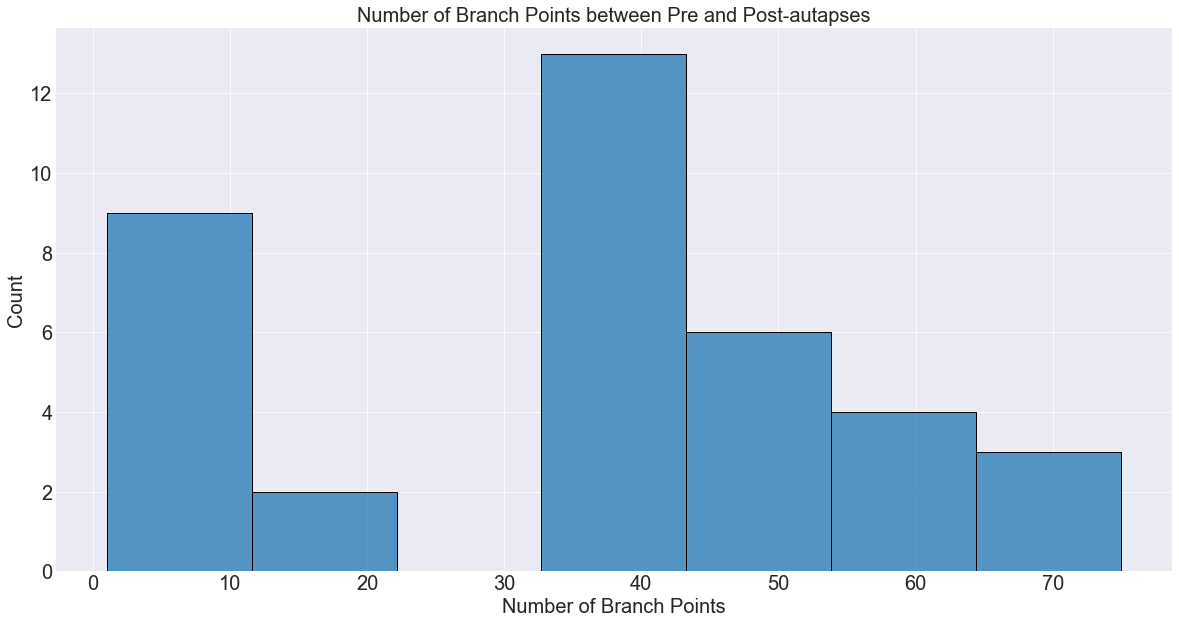

In [63]:
plt.clf()

fig, ax = plt.subplots(figsize = (20,10))

sns.histplot(n_inter_branch_point, ax = ax)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('Number of Branch Points', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.title('Number of Branch Points between Pre and Post-autapses', fontsize = 20)

plt.show()

#### ~Geodesic distances between pre and post nodes to centre node~
#### Geodesic distances between pre and post autapse nodes: 

* x axis = geodesic distance
* y axis = frequency

In [64]:
pre_autapses.head()

,node_id,parent_node_id,confidence,x,y,z,radius,creator,last_edited,skeleton_id,pre_autapse,post_autapse
1077,170157,170155,5,22940.600,8502.0360,12560.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706,1,0
2540,217320,184666,5,11929.320,9918.1370,5520.0,4.0,dakinyemi,2022-03-29 10:06:51+00:00,355706,1,0
2547,202612,202614,5,16032.431,8072.2964,11500.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706,1,0
2617,203981,203964,5,22162.225,7202.6123,13120.0,4.0,rferber,2022-03-29 10:06:51+00:00,355706,1,0
2618,203985,281992,5,20748.260,6836.2200,13300.0,4.0,rferber,2022-03-29 10:06:51+00:00,355706,1,0


In [65]:
# list(pre_autapse_node_to_post.keys())

In [66]:
# pre_autapse_node_to_post

In [67]:
autapses

,node_id,parent_node_id,confidence,x,y,z,radius,creator,last_edited,skeleton_id,pre_autapse,post_autapse
553,139346,161143,5,12910.070,8410.8900,4580.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706,0,1
818,136900,319715,5,12213.313,8396.7430,9840.0,4.0,dakinyemi,2022-03-29 10:06:51+00:00,355706,0,1
967,166337,289099,5,17850.176,10600.8580,9100.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706,0,1
1077,170157,170155,5,22940.600,8502.0360,12560.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706,1,0
2024,149733,287549,5,21232.080,6632.4300,13300.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
29461,170010,497388,5,22088.428,8771.1770,6500.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706,0,1
29495,193869,193871,5,22655.244,8440.1100,6500.0,4.0,smeyer,2022-03-29 10:06:51+00:00,355706,1,0
29533,326016,193471,5,22399.863,9457.1710,10560.0,4.0,jrybak,2022-03-29 10:06:51+00:00,355706,0,1
29705,161017,161015,5,13314.292,6094.0024,3400.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706,1,0


In [68]:
post_autapse_nodes = []

for i in list(chain.from_iterable(list(pre_autapse_node_to_post.values()))):
    
    if type(i) == np.int64:
        
        post_autapse_nodes.append(i)
        
    else:
        
        post_autapse_nodes.append(i[0])

In [69]:
pre_autapse_node_to_post = dict(zip(list(pre_autapse_node_to_post.keys()), post_autapse_nodes))

In [70]:
pre_autapse_node_to_post

{170157: 170160,
 217320: 319626,
 202612: 293488,
 203981: 164671,
 203985: 149733,
 326013: 326016,
 123365: 123382,
 202936: 202909,
 201622: 124105,
 236474: 236472,
 174357: 188375,
 280230: 390681,
 149435: 497973,
 235058: 319657,
 123713: 165286,
 196875: 287601,
 161281: 296290,
 498023: 390113,
 149824: 149788,
 168995: 168996,
 238932: 191914,
 239769: 498516,
 160958: 264278,
 174179: 166337,
 242692: 158337,
 242981: 182342,
 243624: 322768,
 466278: 365075,
 148534: 148536,
 188167: 136900,
 188271: 139346,
 245085: 245091,
 321960: 145563,
 390155: 241343,
 197730: 168548,
 193869: 170010,
 161017: 196717}

In [71]:
g_mat.loc[170157, 170160]

35520.416169166565

In [72]:
autapse_pre_post_geo_dist = []

for i, j in pre_autapse_node_to_post.items():
    
    val = g_mat.loc[i, j]
    
    autapse_pre_post_geo_dist.append(val)
    

<Figure size 432x288 with 0 Axes>

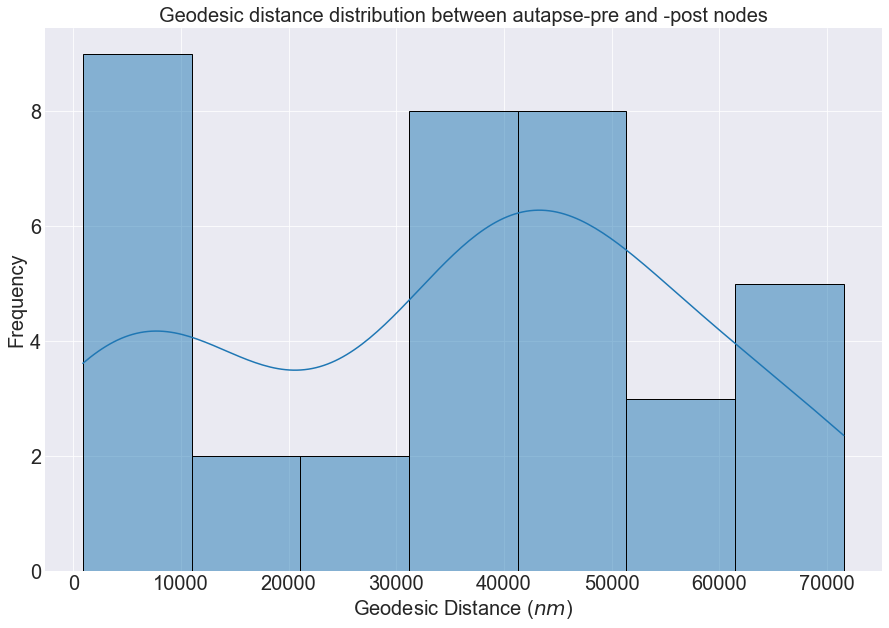

In [73]:
plt.clf()

fig, ax = plt.subplots(figsize = (15,10))

sns.histplot(autapse_pre_post_geo_dist, kde = True)

plt.ylabel('Frequency', fontsize = 20)
plt.xlabel('Geodesic Distance ($nm$)', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Geodesic distance distribution between autapse-pre and -post nodes', fontsize = 20)

plt.show()

In [74]:
pre_autapses = autapses[autapses.pre_autapse == 1].copy()
post_autapses = autapses[autapses.post_autapse == 1].copy()

In [75]:
centre_list = [118212, 504590]

In [76]:
g_mat_centre = g_mat[g_mat.index == centre_list[0]].copy()

In [77]:
g_mat_centre = g_mat_centre.T.copy()
# g_mat_soma

In [78]:
pre_autapse_dist = g_mat_soma[np.isin(g_mat_centre.index, pre_autapses.node_id)].copy()

In [79]:
post_autapse_dist = g_mat_soma[np.isin(g_mat_centre.index, post_autapses.node_id)].copy()

In [80]:
pal = sns.color_palette('turbo', 2)
pal

[(0.10342, 0.896, 0.715), (0.98, 0.73, 0.22161)]

In [251]:
np.linspace(0, 80000, 33)

array([    0.,  2500.,  5000.,  7500., 10000., 12500., 15000., 17500.,
       20000., 22500., 25000., 27500., 30000., 32500., 35000., 37500.,
       40000., 42500., 45000., 47500., 50000., 52500., 55000., 57500.,
       60000., 62500., 65000., 67500., 70000., 72500., 75000., 77500.,
       80000.])

/Users/admin/opt/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<Figure size 432x288 with 0 Axes>

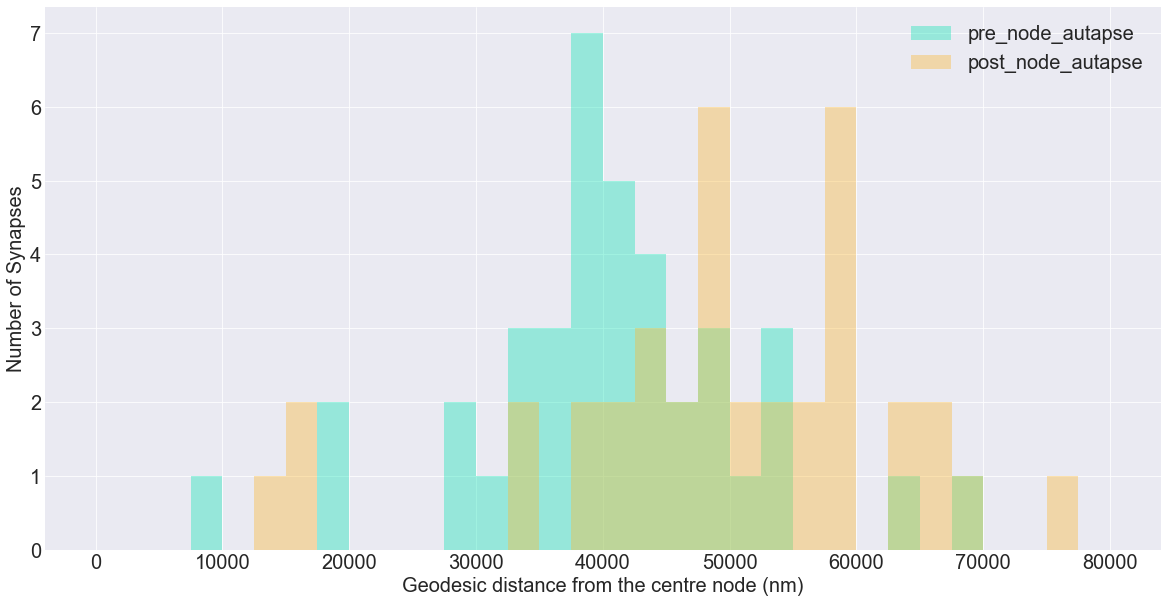

In [252]:
plt.style.use('seaborn-darkgrid')

plt.clf()

fig, ax = plt.subplots(figsize = (20,10))

sns.distplot(pre_autapse_dist.values, bins = np.linspace(0, 80000, 33),
             label = 'pre_node_autapse', ax = ax, color = pal[0], kde = False)

sns.distplot(post_autapse_dist.values, bins = np.linspace(0, 80000, 33),
             label = 'post_node_autapse', ax = ax, color = pal[1], kde = False)

plt.legend(prop = {'size' : 20})

plt.xlabel('Geodesic distance from the centre node (nm)', fontsize = 20)
plt.ylabel('Number of Synapses', fontsize = 20)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.show()

# Dendrogram of autapse pairs

* for each pair of pre and post autapse
* give them each a colour
* colour the pre and post node the same colour

In [102]:
# fetching the node table
node_table = pymaid.get_node_table(navis_n.id)

# removing na tags from the node table
node_table = node_table[~node_table.tags.isna()].copy()

INFO  : Retrieving 1 node table(s)... (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : 29741 nodes retrieved. Creating table... (pymaid)


Creating table:   0%|          | 0/1 [00:00<?, ?it/s]

In [103]:
autapses = node_table[['autapse' in i for i in node_table.tags.tolist()]].copy()
autapses

,node_id,parent_node_id,confidence,x,y,z,radius,creator,last_edited,skeleton_id,reviewers,tags
553,139346,161143,5,12910.070,8410.8900,4580.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706,[dakinyemi],"[post 5, autapse]"
818,136900,319715,5,12213.313,8396.7430,9840.0,4.0,dakinyemi,2022-03-29 10:06:51+00:00,355706,NaN,"[post 6, autapse]"
967,166337,289099,5,17850.176,10600.8580,9100.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706,NaN,"[post 8, autapse]"
1077,170157,170155,5,22940.600,8502.0360,12560.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706,NaN,"[pre 25, autapse]"
2024,149733,287549,5,21232.080,6632.4300,13300.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706,NaN,"[post 21, autapse]"
...,...,...,...,...,...,...,...,...,...,...,...,...
29461,170010,497388,5,22088.428,8771.1770,6500.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706,NaN,"[post 16, autapse, ends]"
29495,193869,193871,5,22655.244,8440.1100,6500.0,4.0,smeyer,2022-03-29 10:06:51+00:00,355706,"[smeyer, eschumann, dakinyemi, lgruber]","[pre 16, autapse]"
29533,326016,193471,5,22399.863,9457.1710,10560.0,4.0,jrybak,2022-03-29 10:06:51+00:00,355706,NaN,"[post 33, autapse]"
29705,161017,161015,5,13314.292,6094.0024,3400.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706,NaN,"[autapse, pre 18]"


Missing node pair annotations:

* pre 17
* post 21
* post 39
* ~pre 40~
* ~post 40~
* pre 41
* post 48

* need a dictionary of pre node to post node

In [104]:
unique_posts = np.unique(list(chain.from_iterable(autapses.tags.values)))[['post' in i for i in np.unique(list(chain.from_iterable(autapses.tags.values)))]]
unique_pres = np.unique(list(chain.from_iterable(autapses.tags.values)))[['pre' in i for i in np.unique(list(chain.from_iterable(autapses.tags.values)))]]

In [105]:
unique_pres

array(['pre 1', 'pre 10', 'pre 11', 'pre 12', 'pre 13', 'pre 14',
       'pre 15', 'pre 16', 'pre 18', 'pre 19', 'pre 2', 'pre 20',
       'pre 21', 'pre 22', 'pre 23', 'pre 24', 'pre 25', 'pre 26',
       'pre 27', 'pre 28', 'pre 29', 'pre 3', 'pre 30', 'pre 31',
       'pre 32', 'pre 33', 'pre 34', 'pre 35', 'pre 36', 'pre 37',
       'pre 38', 'pre 39', 'pre 4', 'pre 40', 'pre 5', 'pre 6', 'pre 7',
       'pre 8', 'pre 9'], dtype='<U12')

In [106]:
pre_indexes = []

for i in unique_pres: 
    
    val = i.split(" ")
    val = val[1]
    val = int(val)
    
    pre_indexes.append(val)

In [107]:
print(pre_indexes)

[1, 10, 11, 12, 13, 14, 15, 16, 18, 19, 2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4, 40, 5, 6, 7, 8, 9]


In [108]:
pre_node_ids = {}

for i in pre_indexes:
    
    str_search = f'pre {i}'
    #print(str_search)
    
    node_id = autapses[[str_search in i for i in autapses.tags]].node_id.tolist()
    
    if len(node_id) == 1:
        
        pre_node_ids[str_search] = node_id[0]
    
    else:
        
        continue
        

In [109]:
pre_node_ids

{'pre 1': 243624,
 'pre 10': 242981,
 'pre 11': 123365,
 'pre 12': 238932,
 'pre 13': 280230,
 'pre 14': 217320,
 'pre 15': 149824,
 'pre 16': 193869,
 'pre 18': 161017,
 'pre 19': 149435,
 'pre 2': 321960,
 'pre 20': 202612,
 'pre 21': 203985,
 'pre 22': 201622,
 'pre 23': 203981,
 'pre 24': 123713,
 'pre 25': 170157,
 'pre 26': 197730,
 'pre 27': 168995,
 'pre 28': 242692,
 'pre 29': 174357,
 'pre 3': 148534,
 'pre 30': 202936,
 'pre 31': 239769,
 'pre 32': 160958,
 'pre 33': 326013,
 'pre 34': 466278,
 'pre 35': 390155,
 'pre 36': 498023,
 'pre 37': 196875,
 'pre 38': 203999,
 'pre 39': 173282,
 'pre 4': 235058,
 'pre 40': 245085,
 'pre 5': 188271,
 'pre 6': 188167,
 'pre 7': 161281,
 'pre 8': 174179,
 'pre 9': 236474}

In [110]:
unique_posts

array(['post 1', 'post 10', 'post 11', 'post 13', 'post 14', 'post 15',
       'post 16', 'post 17', 'post 18', 'post 19', 'post 2', 'post 20',
       'post 21', 'post 22', 'post 23', 'post 24', 'post 25', 'post 26',
       'post 27', 'post 28', 'post 29', 'post 3', 'post 30', 'post 31',
       'post 32', 'post 33', 'post 34', 'post 35', 'post 36', 'post 37',
       'post 4', 'post 40', 'post 5', 'post 6', 'post 7', 'post 8',
       'post 9'], dtype='<U12')

In [111]:
post_indexes = []

for i in unique_posts: 
    
    val = i.split(" ")
    val = val[1]
    val = int(val)
    
    post_indexes.append(val)

In [112]:
print(post_indexes)

[1, 10, 11, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3, 30, 31, 32, 33, 34, 35, 36, 37, 4, 40, 5, 6, 7, 8, 9]


In [113]:
post_node_ids = {}

for i in post_indexes: 
    
    str_search = f'post {i}'
    
    node_id = autapses[[str_search in i for i in autapses.tags]].node_id.tolist()
    
    if len(node_id) == 1: 
        
        post_node_ids[str_search] = node_id[0]
    
    else:
        
        continue

In [114]:
post_node_ids

{'post 1': 322768,
 'post 10': 182342,
 'post 11': 123382,
 'post 13': 390681,
 'post 14': 319626,
 'post 15': 149788,
 'post 16': 170010,
 'post 17': 148843,
 'post 18': 196717,
 'post 19': 497973,
 'post 2': 145563,
 'post 20': 293488,
 'post 21': 149733,
 'post 22': 124105,
 'post 23': 287648,
 'post 24': 165286,
 'post 25': 170160,
 'post 26': 168548,
 'post 27': 168996,
 'post 28': 158337,
 'post 29': 188375,
 'post 3': 148536,
 'post 30': 202909,
 'post 31': 498516,
 'post 32': 141886,
 'post 33': 326016,
 'post 34': 365075,
 'post 35': 241343,
 'post 36': 390113,
 'post 37': 287601,
 'post 4': 319657,
 'post 40': 245091,
 'post 6': 136900,
 'post 7': 296290,
 'post 8': 166337,
 'post 9': 236472}

* finding pairs

In [115]:
print(pre_indexes)

[1, 10, 11, 12, 13, 14, 15, 16, 18, 19, 2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4, 40, 5, 6, 7, 8, 9]


In [116]:
# post_node_ids

In [117]:
pre_node_to_post_node = {}

for i in pre_indexes:
    
    pre_str = f'pre {i}'
    post_str = f'post {i}'
    
    try: 
        
        pre_node_ids[pre_str]
        post_node_ids[post_str]
        
        pre_node_to_post_node[pre_node_ids[pre_str]] = post_node_ids[post_str]
        
    except KeyError: 
        
        print(i)
        
        

12
38
39
5


In [118]:
autapses[np.isin(autapses.node_id, [242981, 182342])]

,node_id,parent_node_id,confidence,x,y,z,radius,creator,last_edited,skeleton_id,reviewers,tags
6525,182342,242887,5,21109.295,10979.805,9040.0,4.0,eschumann,2022-03-29 10:06:51+00:00,355706,NaN,"[post 10, autapse]"
22207,242981,242979,5,20952.318,10837.668,9060.0,4.0,lgruber,2022-03-29 10:06:51+00:00,355706,NaN,"[pre 10, autapse]"


In [119]:
len(pre_node_to_post_node)

35

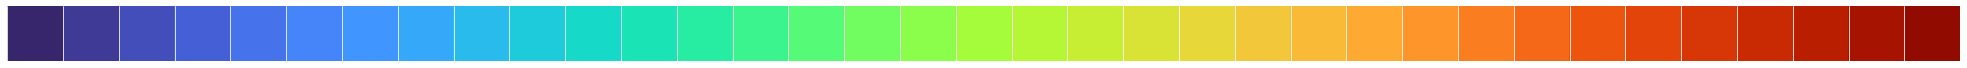

In [120]:
sns.palplot(sns.color_palette('turbo', len(pre_node_to_post_node)))

In [121]:
pal = sns.color_palette('turbo', len(pre_node_to_post_node))

In [122]:
pre_node_to_color = dict(zip(list(pre_node_to_post_node.keys()), pal))
pre_node_to_color

{243624: (0.22111, 0.15223, 0.42558),
 242981: (0.24539, 0.23044, 0.59142),
 123365: (0.2628, 0.30639, 0.72968),
 280230: (0.27334, 0.38008, 0.84037),
 217320: (0.27701, 0.45152, 0.92347),
 149824: (0.27381, 0.52069, 0.97899),
 193869: (0.25425, 0.5895, 0.99896),
 161017: (0.21382, 0.65886, 0.97959),
 149435: (0.15844, 0.73551, 0.92305),
 321960: (0.11639, 0.7974, 0.85559),
 202612: (0.09377, 0.85175, 0.78264),
 203985: (0.10342, 0.896, 0.715),
 201622: (0.15323, 0.93151, 0.64308),
 203981: (0.23449, 0.96065, 0.55614),
 123713: (0.33517, 0.98234, 0.46325),
 170157: (0.44321, 0.99551, 0.37345),
 197730: (0.54658, 0.99907, 0.29581),
 168995: (0.64362, 0.98999, 0.23356),
 242692: (0.71577, 0.96875, 0.20815),
 174357: (0.78563, 0.93579, 0.20336),
 148534: (0.8501, 0.89328, 0.21074),
 202936: (0.90605, 0.84337, 0.22188),
 239769: (0.95039, 0.78823, 0.22831),
 160958: (0.98, 0.73, 0.22161),
 326013: (0.99438, 0.66386, 0.19971),
 466278: (0.99593, 0.58703, 0.16899),
 390155: (0.9836, 0.49291,

In [123]:
# len(list(pre_node_to_post_node.keys()))

In [124]:
all_node_pairs = [list(pre_node_to_post_node.keys()), list(pre_node_to_post_node.values())]
all_node_pairs = list(chain.from_iterable(all_node_pairs))
all_node_pairs

[243624,
 242981,
 123365,
 280230,
 217320,
 149824,
 193869,
 161017,
 149435,
 321960,
 202612,
 203985,
 201622,
 203981,
 123713,
 170157,
 197730,
 168995,
 242692,
 174357,
 148534,
 202936,
 239769,
 160958,
 326013,
 466278,
 390155,
 498023,
 196875,
 235058,
 245085,
 188167,
 161281,
 174179,
 236474,
 322768,
 182342,
 123382,
 390681,
 319626,
 149788,
 170010,
 196717,
 497973,
 145563,
 293488,
 149733,
 124105,
 287648,
 165286,
 170160,
 168548,
 168996,
 158337,
 188375,
 148536,
 202909,
 498516,
 141886,
 326016,
 365075,
 241343,
 390113,
 287601,
 319657,
 245091,
 136900,
 296290,
 166337,
 236472]

In [125]:
# pre_node_to_post_node

In [126]:
post_node_to_pre_node = {i:j for j, i in pre_node_to_post_node.items()}
# post_node_to_pre_node

In [127]:
cols = []

for i in all_node_pairs: 
    
    if np.isin(i, list(pre_node_to_color.keys())):
        
        temp_col = pre_node_to_color[i]
        
        cols.append(temp_col)
        
    else:
        
        temp_val = post_node_to_pre_node[i]
        temp_col = pre_node_to_color[temp_val]
        cols.append(temp_col)

In [128]:
all_node_to_color = dict(zip(all_node_pairs, cols))

#### only selecting n autapse pairs 

In [129]:
import itertools

In [130]:
# n_pairs = 2, selecting 2 pairs 

n_pairs = 6

n_autapse_to_plot = dict(itertools.islice(pre_node_to_post_node.items(), n_pairs))
n_autapse_to_plot

{243624: 322768,
 242981: 182342,
 123365: 123382,
 280230: 390681,
 217320: 319626,
 149824: 149788}

In [131]:
subset_node_to_color = dict(zip(list(chain.from_iterable(n_autapse_to_plot.items())), 
                                [all_node_to_color[i] for i in list(chain.from_iterable(n_autapse_to_plot.items()))]))

* ~method to increase distances between branches~ 
* do this in illustrator

Plotting Tree...
Plotting soma


<Figure size 432x288 with 0 Axes>

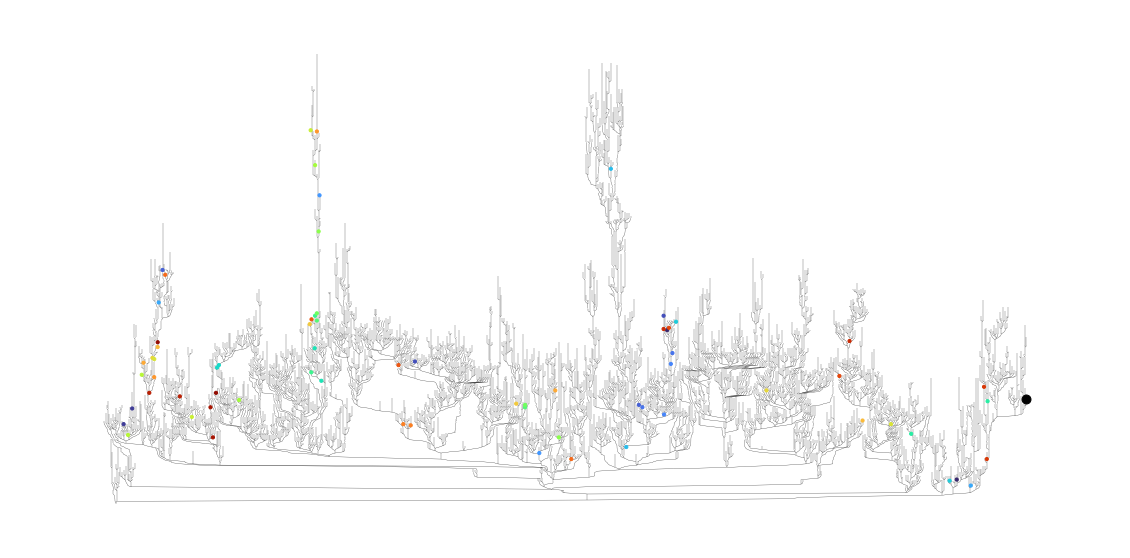

In [132]:
plt.clf()

fig, ax = plt.subplots(figsize = (20,10))

nbd.plot_dendrogram_from_graph(g, pos, navis_n_prep, 
                               highlight_nodes=all_node_to_color, plot_connectors = False)

plt.show()

Plotting Tree...
Plotting soma


<Figure size 432x288 with 0 Axes>

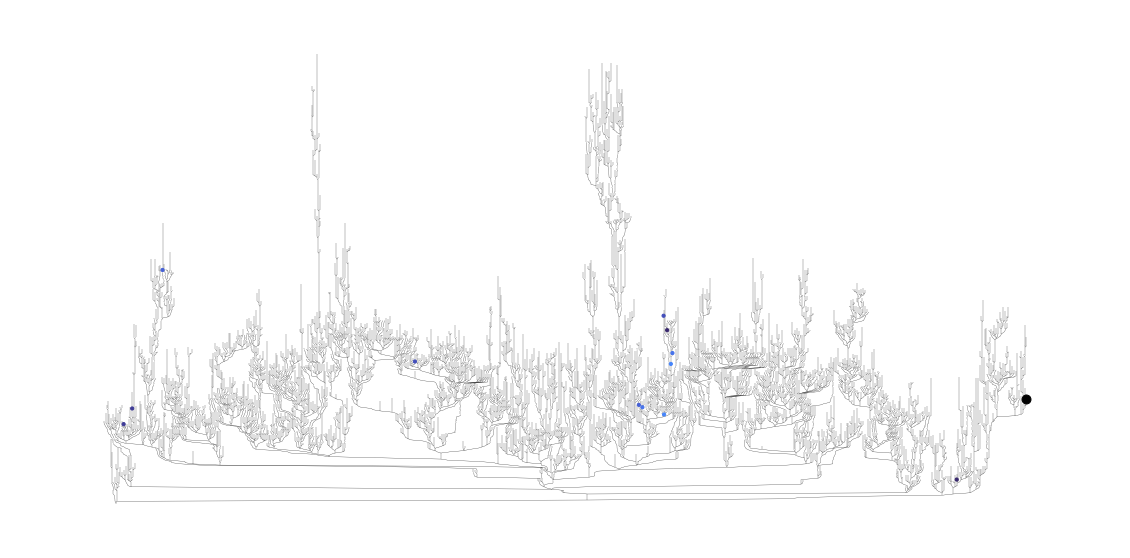

In [133]:
plt.clf()

fig, ax = plt.subplots(figsize = (20,10))

nbd.plot_dendrogram_from_graph(g, pos, navis_n_prep, 
                               highlight_nodes=subset_node_to_color, plot_connectors = False)

plt.show()

In [134]:
n_outputs_to_LN = np.array([sum(k) for k in [np.isin(i, LN) for i in pre_con_details.postsynaptic_to]])
n_outputs_to_LN

outputs_to_LN = pre_con_details[n_outputs_to_LN > 0].copy()
outputs_to_LN

,connector_id,presynaptic_to,postsynaptic_to,presynaptic_to_node,postsynaptic_to_node
0,83487,355706,"[87662, 151172, 140064, 233415, 238845, 365526...",83486,"[83494, 83492, 83495, 83490, 83488, 83491, 834..."
1,83728,355706,"[203594, 213643, 214560, 352156]",83729,"[83730, 83731, 83732, 83733]"
2,83739,355706,"[237362, 88083, 88088, 214560, 171885, 233415,...",83667,"[83759, 83752, 83753, 83740, 83763, 83754, 837..."
3,83772,355706,"[88155, 181985, 203594]",83773,"[83775, 83778, 83776]"
4,83785,355706,"[88192, 88207, 88212, 191107, 178291]",83786,"[83788, 83791, 83792, 83789, 83787]"
...,...,...,...,...,...
538,518298,355706,"[183406, 319423, 198761]",112578,"[518305, 190796, 176233]"
539,518601,355706,"[181985, 151172, 214462, 147008]",321955,"[518604, 518605, 518611, 518612]"
540,520988,355706,"[201801, 208693, 135742, 208704, 221391]",520989,"[520990, 520991, 520992, 364081, 520993]"
543,522382,355706,"[274134, 260683, 227796, 255362]",522383,"[522381, 522384, 282915, 179114]"


In [135]:
n_outputs_to_OSN = np.array([sum(k) for k in [np.isin(i, OSN) for i in pre_con_details.postsynaptic_to]])
n_outputs_to_OSN


outputs_to_OSN = pre_con_details[n_outputs_to_OSN > 0].copy()
outputs_to_OSN

,connector_id,presynaptic_to,postsynaptic_to,presynaptic_to_node,postsynaptic_to_node
15,120109,355706,"[126961, 150421, 355706]",160952,"[118555, 118196, 148843]"
283,166379,355706,"[145512, 282267, 146277, 190082, 145512, 198761]",203274,"[264334, 166384, 166380, 166383, 166381, 166382]"
398,190911,355706,"[124777, 256216, 262965, 214758, 262965, 17188...",203491,"[286634, 190912, 190913, 190915, 190918, 19091..."
415,202935,355706,"[145859, 112025, 355706]",202936,"[202937, 202938, 202909]"
447,236473,355706,"[185354, 192197, 140064, 112025, 355706]",236474,"[236476, 236475, 236477, 111197, 236472]"
518,326014,355706,"[355706, 190555, 185354, 113676]",326013,"[326016, 326015, 295418, 326024]"
529,466277,355706,"[134998, 166347, 355706]",466278,"[135542, 466279, 365075]"
531,475801,355706,"[233415, 188300, 112025]",193840,"[473866, 475802, 475803]"


In [136]:
inputs_from_LN = np.isin(post_con_details.presynaptic_to, LN)
inputs_from_LN = post_con_details[inputs_from_LN].copy()
inputs_from_LN

all_LN_nodes = np.array(list(chain.from_iterable(inputs_from_LN.postsynaptic_to_node)))
all_LN_nodes

LN_input_nodes_to_PN = all_LN_nodes[np.isin(list(chain.from_iterable(inputs_from_LN.postsynaptic_to_node)), n.nodes.node_id)]

In [137]:
inputs_from_OSN = np.isin(post_con_details.presynaptic_to, OSN)
inputs_from_OSN = post_con_details[inputs_from_OSN].copy()

all_OSN_nodes = np.array(list(chain.from_iterable(inputs_from_OSN.postsynaptic_to_node)))

OSN_input_nodes_to_PN = all_OSN_nodes[np.isin(list(chain.from_iterable(inputs_from_OSN.postsynaptic_to_node)), n.nodes.node_id)]

## Determining Strahler order

In [138]:
navis_n = navis.TreeNeuron(n)

In [139]:
navis.strahler_index(navis_n)

,
type,navis.TreeNeuron
name,PN#1
id,355706
n_nodes,29741
n_connectors,4108
n_branches,2578
n_leafs,2635
cable_length,5078860.0
soma,"[116683, 245257, 118921, 138326, 139547, 11690..."
units,1 dimensionless


In [140]:
navis_n.nodes

,node_id,parent_id,creator_id,x,y,z,radius,confidence,type,strahler_index
0,116683,116681,6,10542.025391,4977.915039,8620.0,4.0,5,slab,1
1,245257,128539,9,12905.839844,3740.729980,5320.0,4.0,5,end,1
2,118921,118920,6,10636.865234,8978.830078,10640.0,4.0,5,end,1
3,138326,123696,9,23033.912109,8111.868652,10560.0,4.0,5,slab,2
4,139547,167388,5,13481.759766,10496.405273,7820.0,4.0,5,branch,3
...,...,...,...,...,...,...,...,...,...,...
29736,370580,83477,26,9256.009766,5720.631348,4640.0,4.0,5,slab,1
29737,370531,370532,26,7273.603516,5406.693359,6260.0,4.0,5,slab,1
29738,370530,370531,26,7293.163574,5462.439453,6300.0,4.0,5,slab,1
29739,370529,370530,26,7299.031738,5510.361328,6340.0,4.0,5,slab,1


In [141]:
node_to_SI = dict(zip(navis_n.nodes.node_id, navis_n.nodes.strahler_index))
presyn_to_SI = dict(Counter([node_to_SI[i] for i in navis_n.presynapses.node_id.values]).most_common())
postsyn_to_SI = dict(Counter([node_to_SI[i] for i in navis_n.postsynapses.node_id.values]).most_common())

In [142]:
presyn_x = sorted(presyn_to_SI.keys())
presyn_y = [presyn_to_SI[i] for i in presyn_x]

postsyn_x = sorted(postsyn_to_SI.keys())
postsyn_y = [postsyn_to_SI[i] for i in postsyn_x]

autapse_pre = Counter([node_to_SI[i] for i in list(pre_node_ids.values())])
autapse_pre = list(autapse_pre.values())

autapse_post = Counter([node_to_SI[i] for i in list(post_node_ids.values())])
autapse_post = dict(zip(sorted(autapse_post.keys()), [autapse_post[i] for i in sorted(autapse_post.keys())]))
autapse_post = list(autapse_post.values())

In [143]:
strahler_df = pd.DataFrame(index = [i+1 for i in range(navis_n.nodes.strahler_index.max())],
                           columns = ['presyn','postsyn','autapse_pre','autapse_post'], data=0.0)

strahler_df.index.name = 'strahler'
strahler_df

,presyn,postsyn,autapse_pre,autapse_post
strahler,,,,
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0


In [144]:
for i, j in zip(presyn_x, presyn_y):
    
    strahler_df.loc[i, 'presyn'] = j
    
for i, j in zip(postsyn_x, postsyn_y):
    
    strahler_df.loc[i, 'postsyn'] = j

for i, j in enumerate(autapse_pre):
    
    strahler_df.loc[i+1, 'autapse_pre'] = j
    
for i, j in enumerate(autapse_post):
    
    strahler_df.loc[i+1, 'autapse_post'] = j

In [145]:
strahler_df

,presyn,postsyn,autapse_pre,autapse_post
strahler,,,,
1,133.0,2781.0,9.0,27.0
2,171.0,463.0,13.0,6.0
3,110.0,202.0,5.0,2.0
4,90.0,69.0,8.0,1.0
5,36.0,48.0,4.0,0.0
6,0.0,0.0,0.0,0.0
7,2.0,0.0,0.0,0.0
8,3.0,0.0,0.0,0.0


<Figure size 432x288 with 0 Axes>

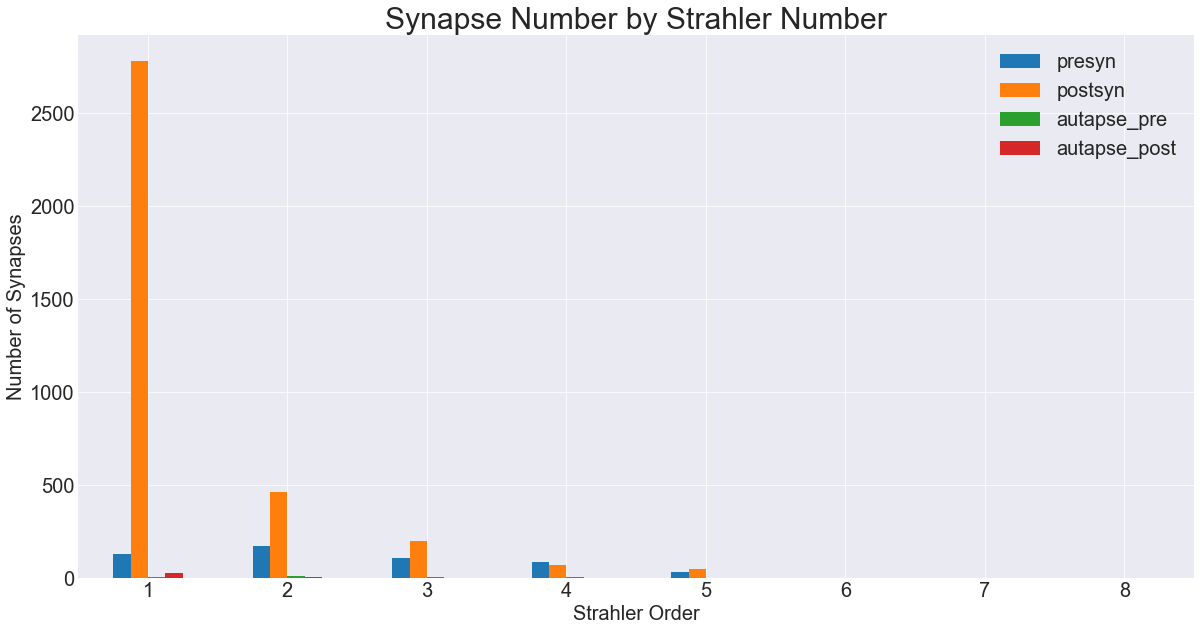

In [146]:
plt.clf()

fig, ax = plt.subplots(figsize = (20,10))

strahler_df.plot(kind = 'bar', ax = ax)

plt.xticks(fontsize = 20, rotation = 0)
plt.yticks(fontsize = 20)

plt.ylabel('Number of Synapses', fontsize = 20)
plt.xlabel('Strahler Order', fontsize = 20)

plt.title('Synapse Number by Strahler Number', fontsize = 30)

plt.legend(prop = {'size' : 20})

plt.show()

<Figure size 432x288 with 0 Axes>

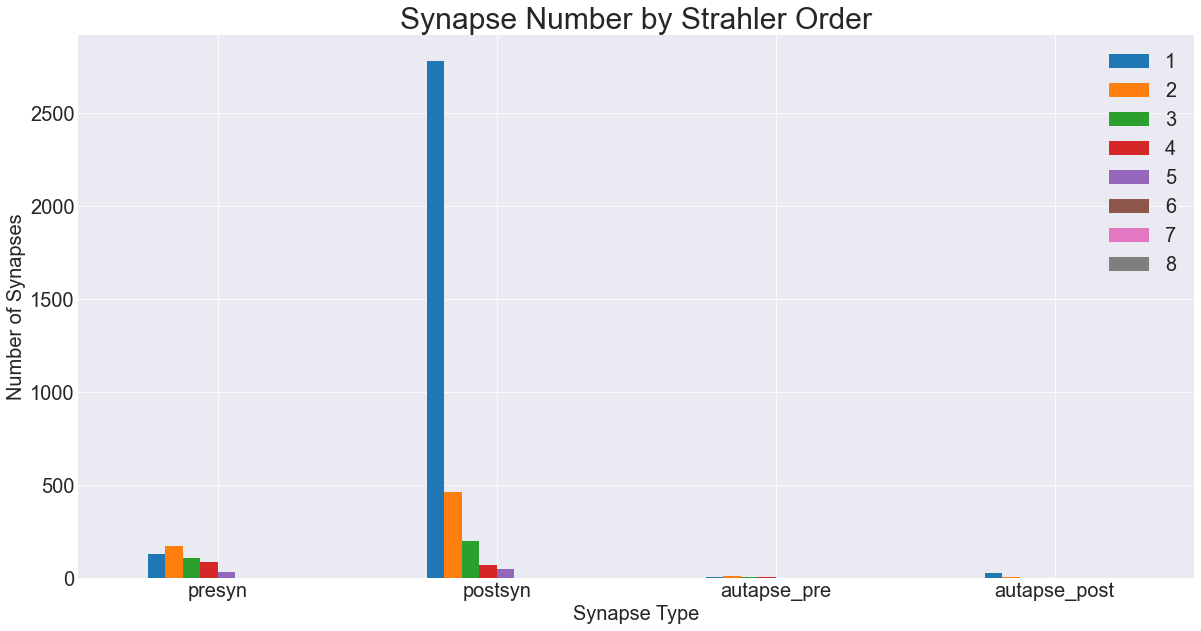

In [147]:
plt.clf()

fig, ax = plt.subplots(figsize = (20,10))

strahler_df.T.plot(kind = 'bar', ax = ax)

plt.xticks(fontsize = 20, rotation = 0)
plt.yticks(fontsize = 20)

plt.ylabel('Number of Synapses', fontsize = 20)
plt.xlabel('Synapse Type', fontsize = 20)

plt.title('Synapse Number by Strahler Order', fontsize = 30)

plt.legend(prop = {'size' : 20})

plt.show()

In [148]:
strahler_df_norm = strahler_df / strahler_df.sum(axis = 0).copy()

In [149]:
strahler_df

,presyn,postsyn,autapse_pre,autapse_post
strahler,,,,
1,133.0,2781.0,9.0,27.0
2,171.0,463.0,13.0,6.0
3,110.0,202.0,5.0,2.0
4,90.0,69.0,8.0,1.0
5,36.0,48.0,4.0,0.0
6,0.0,0.0,0.0,0.0
7,2.0,0.0,0.0,0.0
8,3.0,0.0,0.0,0.0


In [150]:
strahler_df_norm

,presyn,postsyn,autapse_pre,autapse_post
strahler,,,,
1,0.244037,0.780522,0.230769,0.750000
2,0.313761,0.129947,0.333333,0.166667
3,0.201835,0.056694,0.128205,0.055556
4,0.165138,0.019366,0.205128,0.027778
5,0.066055,0.013472,0.102564,0.000000
6,0.000000,0.000000,0.000000,0.000000
7,0.003670,0.000000,0.000000,0.000000
8,0.005505,0.000000,0.000000,0.000000


<Figure size 432x288 with 0 Axes>

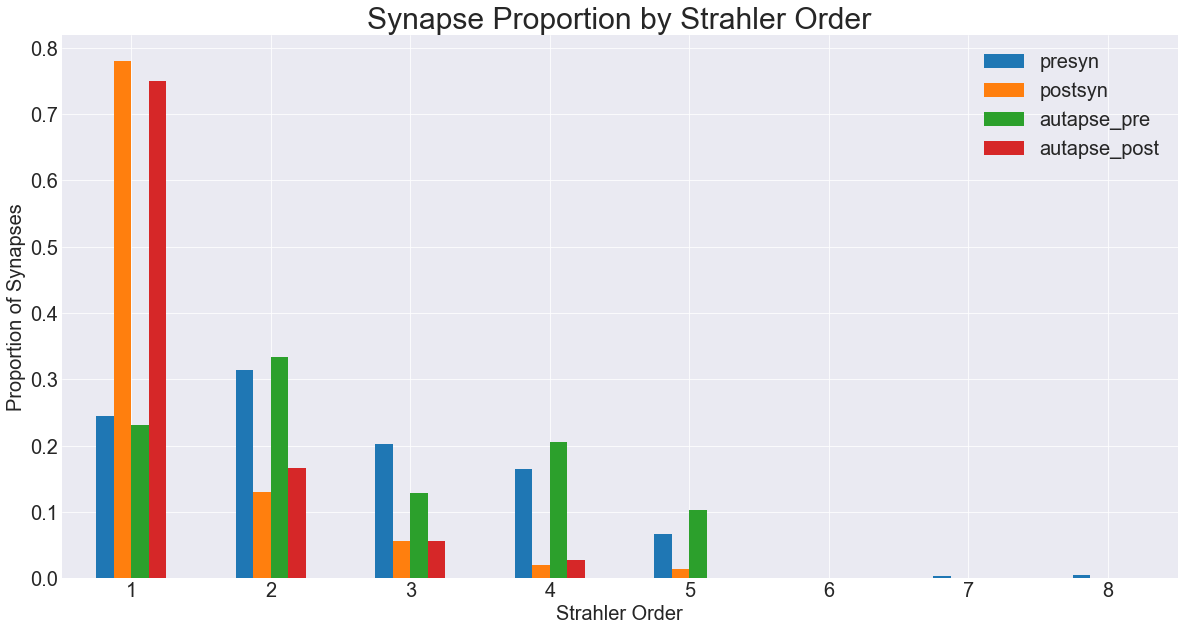

In [151]:
plt.clf()

fig, ax = plt.subplots(figsize = (20,10))

strahler_df_norm.plot(kind = 'bar', ax = ax)

plt.xticks(fontsize = 20, rotation = 0)
plt.yticks(fontsize = 20)

plt.ylabel('Proportion of Synapses', fontsize = 20)
plt.xlabel('Strahler Order', fontsize = 20)

plt.title('Synapse Proportion by Strahler Order', fontsize = 30)

plt.legend(prop = {'size' : 20})

plt.show()

<Figure size 432x288 with 0 Axes>

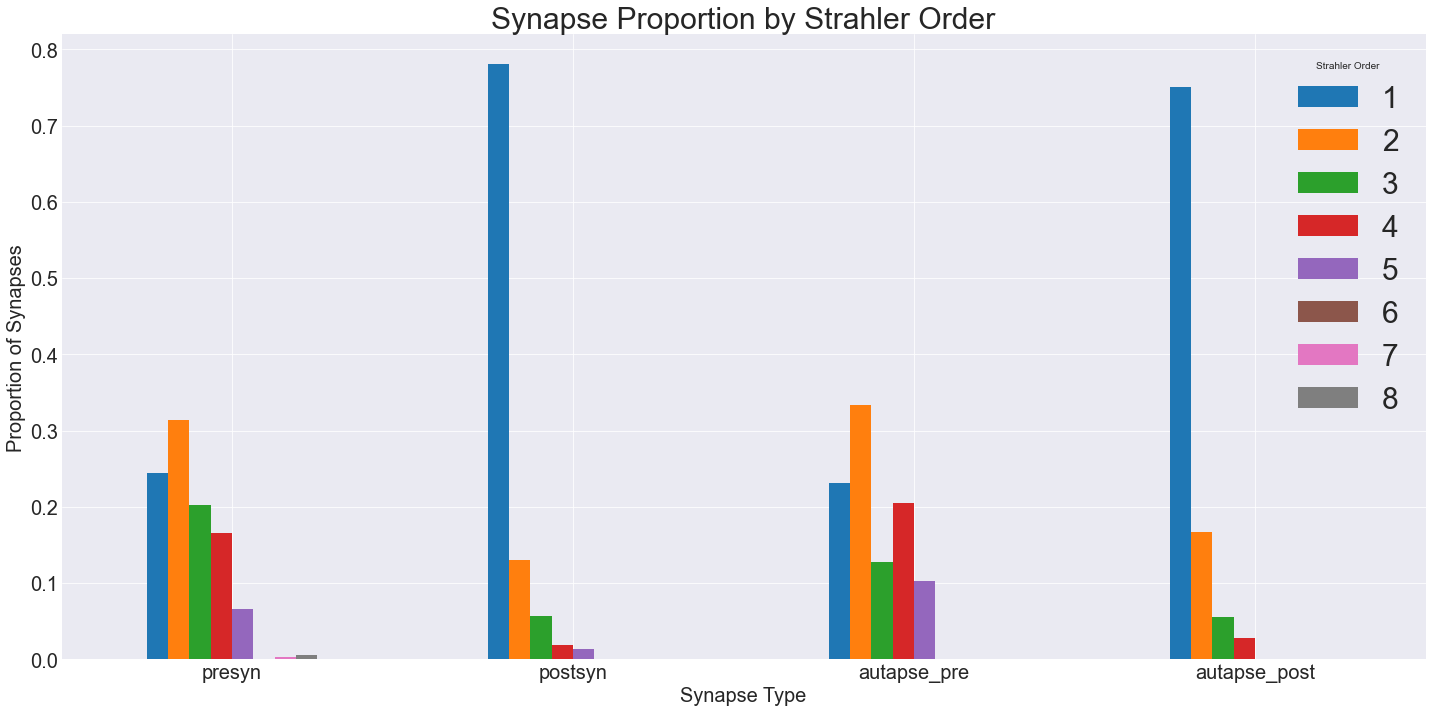

In [152]:
plt.clf()

fig, ax = plt.subplots(figsize = (20,10))

strahler_df_norm.T.plot(kind = 'bar', ax = ax)

plt.xticks(fontsize = 20, rotation = 0)
plt.yticks(fontsize = 20)

plt.ylabel('Proportion of Synapses', fontsize = 20)
plt.xlabel('Synapse Type', fontsize = 20)

plt.title('Synapse Proportion by Strahler Order', fontsize = 30)

plt.legend(prop = {'size' : 30}, title='Strahler Order', fontsize = 'XX-large')

plt.tight_layout()

plt.show()

In [153]:
LN_OSN_strahler_df = pd.DataFrame(index = [i+1 for i in range(navis_n.nodes.strahler_index.max())],
                           columns = ['LN_outputs','LN_inputs','OSN_outputs','OSN_inputs'], data=0.0)

LN_OSN_strahler_df.index.name = 'strahler'
LN_OSN_strahler_df

,LN_outputs,LN_inputs,OSN_outputs,OSN_inputs
strahler,,,,
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0


In [154]:
SI_LN_outputs = sorted(Counter([node_to_SI[i] for i in outputs_to_LN.presynaptic_to_node]).most_common())
SI_OSN_outputs = sorted(Counter([node_to_SI[i] for i in outputs_to_OSN.presynaptic_to_node]).most_common())
SI_LN_inputs = sorted(Counter([node_to_SI[i] for i in LN_input_nodes_to_PN]).most_common())
SI_OSN_inputs = sorted(Counter([node_to_SI[i] for i in OSN_input_nodes_to_PN]).most_common())

In [155]:
for i, j in SI_LN_outputs:
    
    LN_OSN_strahler_df.loc[i, 'LN_outputs'] = j

for i, j in SI_OSN_outputs:
    
    LN_OSN_strahler_df.loc[i, 'OSN_outputs'] = j

for i, j in SI_LN_inputs:
    
    LN_OSN_strahler_df.loc[i, 'LN_inputs'] = j
    
for i, j in SI_OSN_inputs:
    
    LN_OSN_strahler_df.loc[i, 'OSN_inputs'] = j

<Figure size 432x288 with 0 Axes>

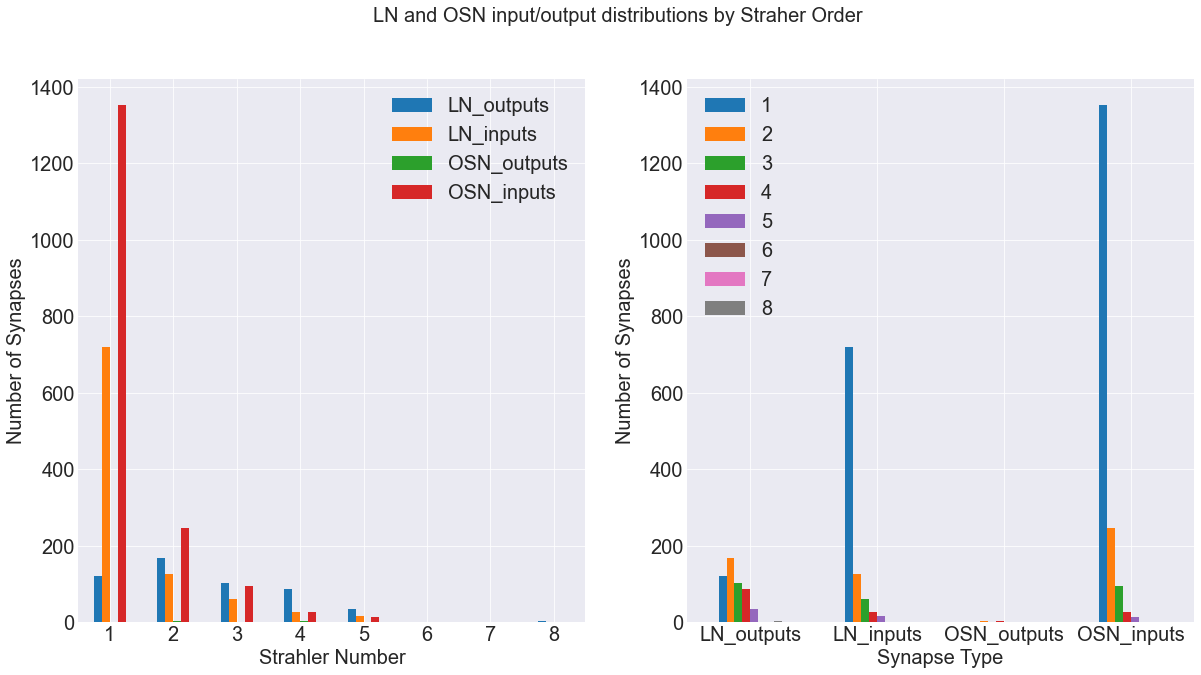

In [156]:
plt.clf()

fig = plt.figure(figsize = (20,10))

ax1 = fig.add_subplot(121)
LN_OSN_strahler_df.plot(kind = 'bar', ax = ax1)
plt.xticks(rotation = 0, fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('Number of Synapses', fontsize = 20)
plt.xlabel('Strahler Number', fontsize = 20)
plt.legend(prop = {'size' : 20})

ax2 = fig.add_subplot(122)
LN_OSN_strahler_df.T.plot(kind = 'bar', ax = ax2)
plt.xticks(rotation = 0, fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('Number of Synapses', fontsize = 20)
plt.xlabel('Synapse Type', fontsize = 20)
plt.legend(prop = {'size' : 20})

plt.suptitle('LN and OSN input/output distributions by Straher Order', fontsize = 20)

plt.show()

#### proportion of synapses

* Dividing the number of LN/OSN inputs/outputs by the total number of post-/pre-synapses

In [157]:
LN_OSN_strahler_df_norm = LN_OSN_strahler_df.copy()

In [158]:
LN_OSN_strahler_df_norm.LN_outputs = LN_OSN_strahler_df_norm.LN_outputs / navis_n.presynapses.shape[0]
LN_OSN_strahler_df_norm.LN_inputs = LN_OSN_strahler_df_norm.LN_inputs / navis_n.postsynapses.shape[0]
LN_OSN_strahler_df_norm.OSN_outputs = LN_OSN_strahler_df_norm.OSN_outputs / navis_n.presynapses.shape[0]
LN_OSN_strahler_df_norm.OSN_inputs = LN_OSN_strahler_df_norm.OSN_inputs / navis_n.postsynapses.shape[0]
LN_OSN_strahler_df_norm

,LN_outputs,LN_inputs,OSN_outputs,OSN_inputs
strahler,,,,
1,0.223853,0.201796,0.001835,0.380017
2,0.306422,0.035363,0.005505,0.069043
3,0.190826,0.016840,0.001835,0.026382
4,0.159633,0.007578,0.005505,0.007297
5,0.064220,0.004771,0.000000,0.004210
6,0.000000,0.000000,0.000000,0.000000
7,0.003670,0.000000,0.000000,0.000000
8,0.005505,0.000000,0.000000,0.000000


<Figure size 432x288 with 0 Axes>

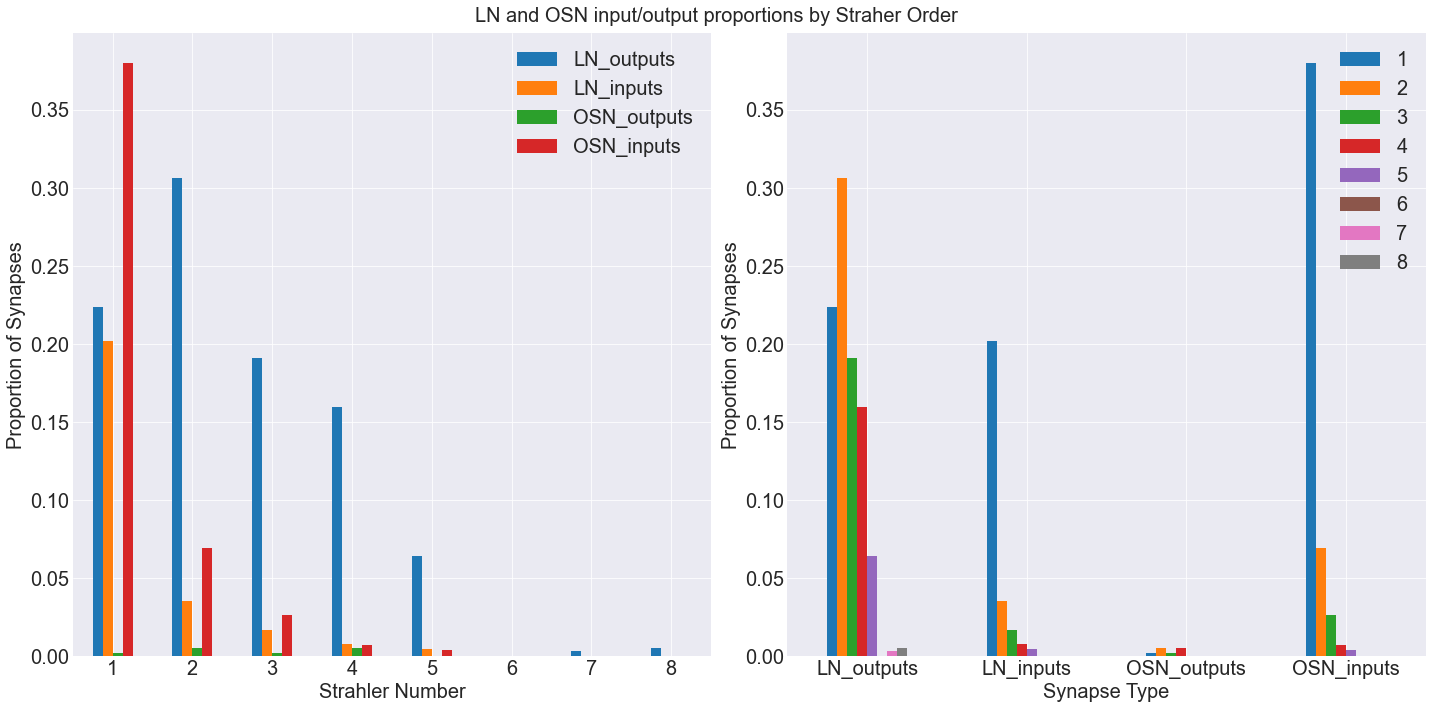

In [159]:
plt.clf()

fig = plt.figure(figsize = (20,10))

ax1 = fig.add_subplot(121)
LN_OSN_strahler_df_norm.plot(kind = 'bar', ax = ax1)
plt.xticks(rotation = 0, fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('Proportion of Synapses', fontsize = 20)
plt.xlabel('Strahler Number', fontsize = 20)
plt.legend(prop = {'size' : 20})

ax2 = fig.add_subplot(122)
LN_OSN_strahler_df_norm.T.plot(kind = 'bar', ax = ax2)
plt.xticks(rotation = 0, fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('Proportion of Synapses', fontsize = 20)
plt.xlabel('Synapse Type', fontsize = 20)
plt.legend(prop = {'size' : 20})

plt.suptitle('LN and OSN input/output proportions by Straher Order', fontsize = 20)

plt.tight_layout()

plt.show()

## Input proportion at each Strahler level - DL5

* I want to show, what I see in the 3D visualization of the PNs in DA2 and DL5 glomerulus, that LN input sites are more abundant at the basal strahler order (6-8) located than at the distal strahler orders; 
* i.e. that dendritic input sites have are organized in specific distal/basal structure .

* Proportion of LN and OSN input sites at each strahler order 
* LN inputs at strahler order X/total number of input sites at strahler order X 
* OSN inputs at strahler order X/total inputs at strahler order X 

In [160]:
# need to find total number of inputs/outputs at each strahler order

In [161]:
LN_OSN_strahler_df_norm.LN_outputs = LN_OSN_strahler_df_norm.LN_outputs / navis_n.presynapses.shape[0]
LN_OSN_strahler_df_norm.LN_inputs = LN_OSN_strahler_df_norm.LN_inputs / navis_n.postsynapses.shape[0]
LN_OSN_strahler_df_norm.OSN_outputs = LN_OSN_strahler_df_norm.OSN_outputs / navis_n.presynapses.shape[0]
LN_OSN_strahler_df_norm.OSN_inputs = LN_OSN_strahler_df_norm.OSN_inputs / navis_n.postsynapses.shape[0]
LN_OSN_strahler_df_norm

,LN_outputs,LN_inputs,OSN_outputs,OSN_inputs
strahler,,,,
1,0.000411,0.000057,0.000003,0.000107
2,0.000562,0.000010,0.000010,0.000019
3,0.000350,0.000005,0.000003,0.000007
4,0.000293,0.000002,0.000010,0.000002
5,0.000118,0.000001,0.000000,0.000001
6,0.000000,0.000000,0.000000,0.000000
7,0.000007,0.000000,0.000000,0.000000
8,0.000010,0.000000,0.000000,0.000000


In [162]:
node_to_strahler = dict(zip(navis_n.nodes.node_id, navis_n.nodes.strahler_index))

In [163]:
presyn = navis_n.presynapses.copy()
presyn['strahler_idx'] = presyn.node_id.map(node_to_strahler)
presyn

,node_id,connector_id,type,x,y,z,strahler_idx
0,243624,163138,0,11695.139648,7728.645020,3900.0,1
4,124063,124062,0,14881.039062,3857.489258,5320.0,5
28,201667,189461,0,15190.580078,4341.012695,3060.0,3
33,245118,245119,0,10965.644531,6065.060059,11240.0,4
34,245164,245173,0,20858.875000,3361.280029,6200.0,2
...,...,...,...,...,...,...,...
4088,272246,272245,0,4991.997559,5176.956543,8520.0,1
4089,272748,185828,0,8610.045898,6668.189941,8060.0,1
4094,281025,162953,0,6470.625000,4465.797363,6320.0,2
4098,282511,186969,0,7499.861816,5928.840820,7660.0,4


In [164]:
n_presyn_per_strahler = dict(presyn.strahler_idx.value_counts())

In [165]:
n_presyn_per_strahler[6] = 0

In [166]:
postsyn = navis_n.postsynapses.copy()
postsyn['strahler_idx'] = postsyn.node_id.map(node_to_strahler)
postsyn

,node_id,connector_id,type,x,y,z,strahler_idx
1,107879,107868,1,19294.970703,11081.795898,8580.0,1
2,116357,135136,1,10528.827148,7378.714355,15120.0,1
3,122951,122946,1,10211.425781,5834.484375,7520.0,1
5,135138,135136,1,10528.827148,7378.714355,15120.0,1
6,138525,138523,1,9164.460938,5921.503418,4520.0,1
...,...,...,...,...,...,...,...
4103,294288,147539,1,7468.527832,3910.333740,6540.0,1
4104,295548,295549,1,10661.462891,4841.250488,6080.0,1
4105,511856,511852,1,3727.265381,9920.504883,9660.0,2
4106,244478,511863,1,5888.645508,10106.325195,8500.0,1


In [167]:
n_postsyn_per_strahler = dict(postsyn.strahler_idx.value_counts())

In [168]:
n_postsyn_per_strahler[6] = 0
n_postsyn_per_strahler[7] = 0
n_postsyn_per_strahler[8] = 0

In [169]:
LN_OSN_strahler_df

,LN_outputs,LN_inputs,OSN_outputs,OSN_inputs
strahler,,,,
1,122.0,719.0,1.0,1354.0
2,167.0,126.0,3.0,246.0
3,104.0,60.0,1.0,94.0
4,87.0,27.0,3.0,26.0
5,35.0,17.0,0.0,15.0
6,0.0,0.0,0.0,0.0
7,2.0,0.0,0.0,0.0
8,3.0,0.0,0.0,0.0


In [170]:
# LN_OSN_strahler_df.LN_outputs / [n_presyn_per_strahler[i] for i in  LN_OSN_strahler_df.index.values]

In [171]:
# LN_OSN_strahler_df.OSN_outputs / [n_presyn_per_strahler[i] for i in  LN_OSN_strahler_df.index.values]

In [178]:
OSN_input_at_each_strah = LN_OSN_strahler_df.OSN_inputs / [n_postsyn_per_strahler[i] for i in  LN_OSN_strahler_df.index.values]

In [179]:
LN_input_at_each_strah = LN_OSN_strahler_df.LN_inputs / [n_postsyn_per_strahler[i] for i in  LN_OSN_strahler_df.index.values]

In [180]:
OSN_input_at_each_strah.replace(np.nan, 0.0, inplace = True)
LN_input_at_each_strah.replace(np.nan, 0.0, inplace = True)

In [181]:
norm_by_total_in_strah = pd.concat([LN_input_at_each_strah, OSN_input_at_each_strah], axis = 1)

<Figure size 432x288 with 0 Axes>

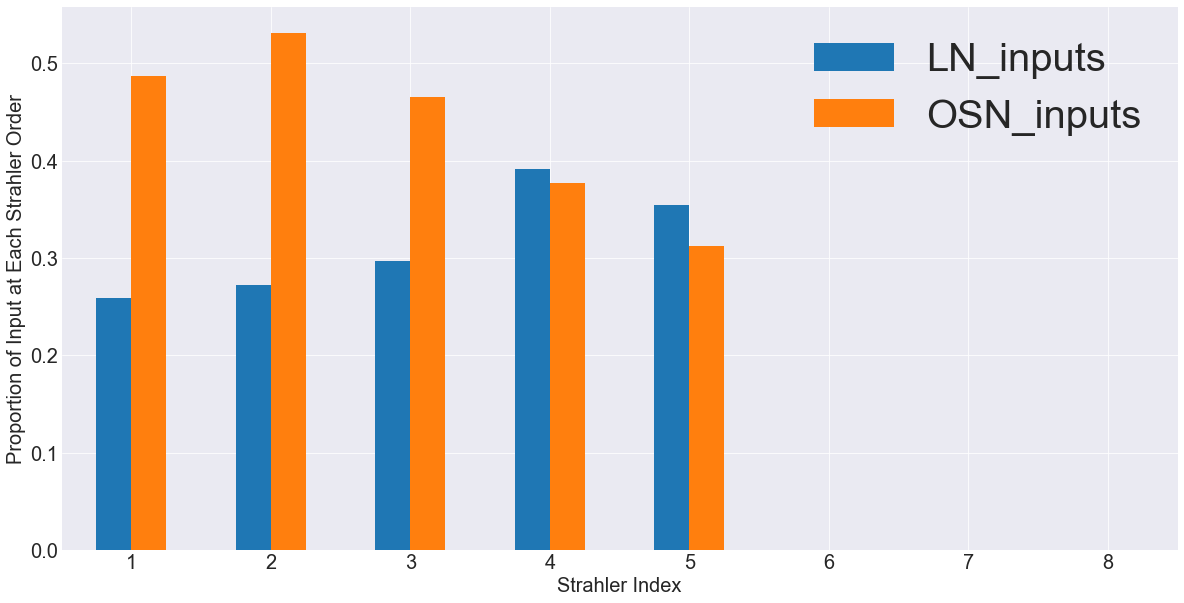

In [182]:
plt.clf()

fig, ax = plt.subplots(figsize = (20,10))

norm_by_total_in_strah.plot.bar(ax=ax)
plt.xticks(rotation = 0, fontsize = 20)
plt.xlabel('Strahler Index', fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('Proportion of Input at Each Strahler Order', fontsize = 20)
plt.legend(prop={'size' : 40})

plt.show()

#### dendrogram of nodes coloured by strahler order 

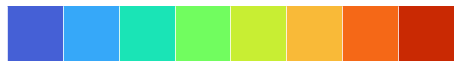

In [183]:
sns.palplot(sns.color_palette('turbo', max(navis_n.nodes.strahler_index)))

In [184]:
pal = sns.color_palette('turbo', max(navis_n.nodes.strahler_index))

In [185]:
strahler_to_color = dict(zip([i+1 for i in range(max(navis_n.nodes.strahler_index))], pal))

In [186]:
node_to_SI_col = dict(zip(node_to_SI.keys(), [strahler_to_color[node_to_SI[i]] for i in node_to_SI.keys()]))

In [ ]:
all_nodes = np.array(list(node_to_SI_col.keys()))
in_navis_n_prep = np.isin(list(node_to_SI_col.keys()), navis_n_prep.nodes.node_id)

In [ ]:
n2SI = {i : node_to_SI_col[i] for i in all_nodes[in_navis_n_prep]}

Plotting Tree...
Plotting soma


KeyError: 525875

<Figure size 432x288 with 0 Axes>

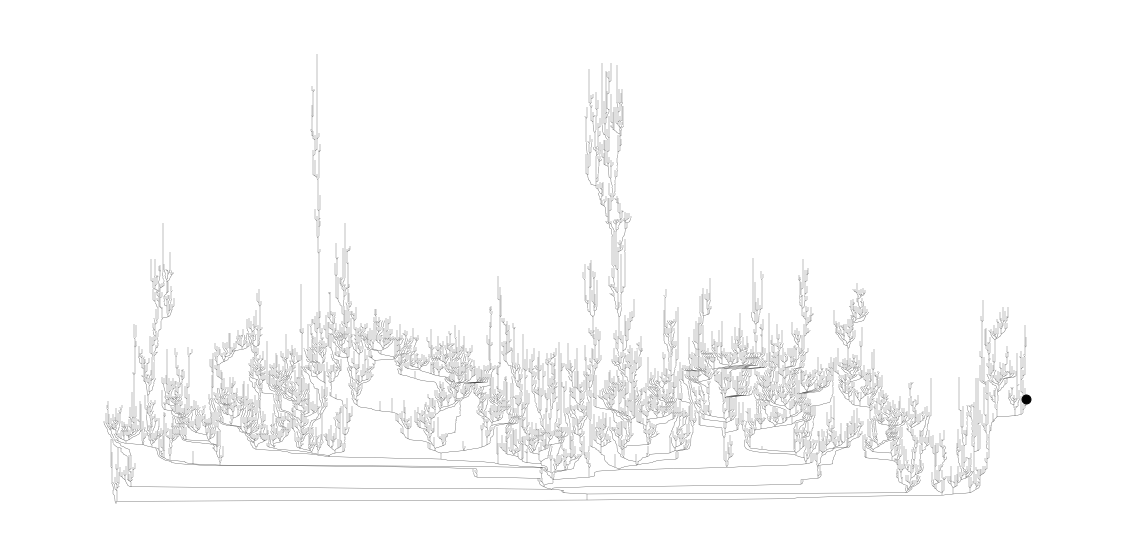

In [191]:
plt.clf()

fig, ax = plt.subplots(figsize = (20,10))

# nbd.plot_dendrogram_from_graph(g, pos, navis_n_prep, highlight_nodes=node_to_SI_col, plot_connectors = False)

nbd.plot_dendrogram_from_graph(g, pos, navis_n_prep, highlight_nodes=n2SI, plot_connectors = False)

plt.show()

In [192]:
# creating legend


legend_elements = []

for i in range(0, len(list(strahler_to_color.keys()))):
    
    
    legend_elements.append(Line2D([i], [0], marker = 's', 
                                  color = strahler_to_color[i+1],
                                  label = f'{i+1}', 
                                  markerfacecolor = strahler_to_color[i+1],
                                  markersize = 60
                                 ))


<Figure size 432x288 with 0 Axes>

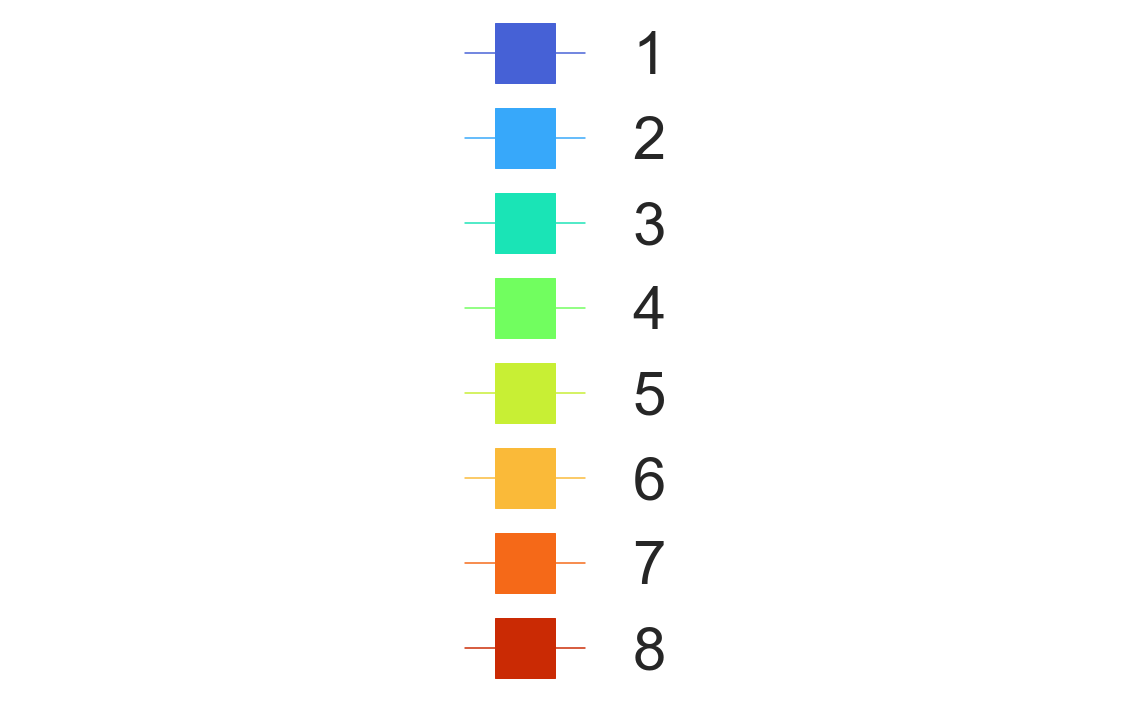

In [193]:
plt.clf()
fig, ax = plt.subplots(figsize = (20,10))

ax.legend(handles = legend_elements, loc= 'center', prop={'size':60})
plt.axis('off')
plt.show()
# plt.savefig(os.getcwd() + '/legend.png', dpi = 100)

#### Visualising PN output and LN input for OSN: 
* need to change instance to project 2

* need to remove the not a branch tags here -not so important for PN

In [194]:
server = "https://catmaid.ice.mpg.de/catmaid_2020.02.15/#"
http_user = 'fly'
http_pw = 'superfly'
project_id = 2

def connect_adult_em():
    return pymaid.CatmaidInstance( server, token, http_user, http_pw, project_id = project_id)

connect_adult_em()

INFO  : Global CATMAID instance set. Caching is ON. (pymaid)


CatmaidInstance at 140512454015824.
Server: https://catmaid.ice.mpg.de/catmaid_2020.02.15/#
Project: 2
Caching True (size limit 128; time limit None)
Cache size: 0.0

In [195]:
n = pymaid.get_neurons(['PN#2'])
n

,
type,CatmaidNeuron
name,PN#2
id,107276
n_nodes,10438
n_connectors,1106
n_branches,820
n_leafs,830
cable_length,1440342.75
soma,None
units,1 nanometer


In [196]:
navis_n = navis.TreeNeuron(n)
navis_n

,
type,navis.TreeNeuron
name,PN#2
id,107276
n_nodes,10438
n_connectors,1106
n_branches,820
n_leafs,830
cable_length,1440342.75
soma,"[9863, 9864, 352985, 9872, 9888, 9893, 9894, 9..."
units,1 dimensionless


### Getting connector details

* creating a mapping between connectors and their presynaptic type
* upstream neurons need to be coloured by whether they are an OSN, LN or PN

* 6 colours: 3 for presyn, 3 for postsyn

In [197]:
pre_connectors = navis_n.connectors[navis_n.connectors.type == 0].connector_id.unique()
post_connectors = navis_n.connectors[navis_n.connectors.type == 1].connector_id.unique()

In [198]:
pre_con_details = pymaid.get_connector_details(pre_connectors)
post_con_details = pymaid.get_connector_details(post_connectors)

CN details:   0%|          | 0/82 [00:00<?, ?it/s]

INFO  : Data for 82 of 82 unique connector IDs retrieved (pymaid)


CN details:   0%|          | 0/780 [00:00<?, ?it/s]

INFO  : Data for 780 of 780 unique connector IDs retrieved (pymaid)


In [199]:
pre_con_details.head()

,connector_id,presynaptic_to,postsynaptic_to,presynaptic_to_node,postsynaptic_to_node
0,8208,107276,"[61924, 2245, 14284, 44325, 112287]",127727,"[8210, 7270, 78619, 78620, 8212]"
1,8713,107276,"[365319, 28640, 262261, 31416, 340241]",56777,"[8715, 8716, 8717, 40473, 8648]"
2,10401,107276,"[229729, 55643, 136226, 33773, 14284]",10407,"[10402, 10406, 10404, 10403, 165456]"
3,10413,107276,"[80434, 103987, 80434, 188763]",10417,"[10415, 103810, 106040, 10416]"
4,10501,107276,"[5040, 33590, 368140]",28765,"[10504, 29291, 10502]"


In [200]:
post_con_details.head()

,connector_id,presynaptic_to,postsynaptic_to,presynaptic_to_node,postsynaptic_to_node
0,7737,2245,"[294656, 44235, 357381, 44235, 23752, 77074, 1...",7744,"[7738, 7741, 7739, 45970, 380547, 97722, 47472]"
1,8124,38640,"[31416, 87425, 107276, 50017, 74856]",517291,"[8118, 8128, 8126, 8125, 332822]"
2,8152,52419,"[2245, 16964, 103653, 77074, 16964, 38640, 335...",70592,"[8154, 26211, 47052, 47343, 47341, 74575, 8189..."
3,8358,17280,"[2245, 107276, 28048, 101487, 19403, 357381]",26234,"[7255, 8359, 8362, 47115, 47350, 8360]"
4,8704,33773,"[107276, 365319, 38640, 14284, 299511, 299511,...",39378,"[8706, 8707, 8708, 42530, 42529, 105605, 8705]"


#### Visualise the OSN with:

* output to PN 
* input from LN

In [201]:
postsyn_neurons = [j for i, j in enumerate(pre_con_details.presynaptic_to.unique()) if j is not None]

In [202]:
postsyn_neurons

[107276]

In [203]:
# ann = pymaid.get_annotations(postsyn_neurons)

In [204]:
presyn_neurons = [j for i, j in enumerate(post_con_details.presynaptic_to.unique()) if j is not None]

In [205]:
ann = pymaid.get_annotations(presyn_neurons)
ann

{'21319': ['contra', 'OSN', 'DA2'],
 '52419': ['OSN', 'contra', 'DA2'],
 '32870': ['OSN', 'DA2'],
 '135022': ['DA2', 'LN', '?'],
 '17763': ['ln', 'DA2'],
 '71286': ['ipsi', 'OSN', 'DA2'],
 '274760': ['ln', 'DA2'],
 '82671': ['short', 'osn', 'DA2'],
 '71797': ['OSN', 'ipsi', 'DA2'],
 '22870': ['OSN', 'DA2'],
 '30223': ['broad', 'LN', 'review', 'DA2'],
 '26718': ['ln', 'DA2'],
 '74856': ['patchy', 'only FFW', 'looping', 'dorsal-posterior', 'LN', 'DA2'],
 '47700': ['contra', 'OSN', 'DA2'],
 '340241': ['DA2', 'LN', 'review'],
 '101554': ['short', 'osn', 'DA2'],
 '48086': ['contra', 'OSN', 'DA2'],
 '96704': ['ln', 'DA2'],
 '33293': ['mPN?', 'DA4m', 'DA2'],
 '368140': ['LN', 'DA2'],
 '81927': ['OSN', 'contra', 'DA2'],
 '9149': ['short', 'DA2', 'osn'],
 '82413': ['OSN', 'contra', 'DA2'],
 '368165': ['ln', 'outside'],
 '27876': ['?', 'LN', 'only output', 'DA2'],
 '295950': ['DA2', 'ln'],
 '30303': ['PN', 'DA2'],
 '154045': ['rybak', 'mPN?', 'DA2', 'LN'],
 '87466': ['OSN', 'ipsi', 'DA2'],
 '294

In [206]:
LN = []
OSN = []
PN = []

for i, j in ann.items():
    
    if 'LN' in ann[i]:
        
        LN.append(int(i))
    
    elif 'OSN' in ann[i]:
        
        OSN.append(int(i))
        
    elif 'DA2' in ann[i]:
        
        PN.append(int(i))
        
# all_usns = list(chain.from_iterable([LN, OSN]))

all_usns = list(chain.from_iterable([LN, PN]))

# coloured_types = ['OSN','LN']
                
coloured_types = ['PN','LN']

In [207]:
PN = postsyn_neurons
PN

[107276]

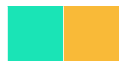

In [208]:
# What colours will we use?
sns.palplot(sns.color_palette('turbo', len(coloured_types)))

In [209]:
# creating a dictionary of skeleton_id to colour

pal = sns.color_palette('turbo', len(coloured_types))
type_to_col = dict(zip(coloured_types, pal))
# osn_to_bid = dict(zip(OSN, [coloured_types[0]] * len(OSN)))
pn_to_bid = dict(zip(PN, [coloured_types[0]] * len(PN)))
ln_to_bid =  dict(zip(LN, [coloured_types[1]] * len(LN)))
# skid_to_type = {**osn_to_bid, **ln_to_bid}

skid_to_type = {**pn_to_bid, **ln_to_bid}

In [210]:
all_neurons = list(chain.from_iterable([PN, LN]))
all_neurons

[107276,
 135022,
 30223,
 74856,
 340241,
 368140,
 27876,
 154045,
 294598,
 50742,
 103987,
 111066,
 23752,
 44235,
 279378,
 70931,
 102932,
 92508,
 105447,
 102411,
 135584,
 29513,
 68084,
 87486,
 136226,
 18069,
 112287,
 136467,
 38640,
 28640,
 188763,
 228627,
 228644,
 229693,
 68714,
 16964,
 14284,
 2245,
 41879,
 42753,
 249525,
 295881,
 253795,
 11470,
 77286,
 44325,
 73596,
 34418,
 41435,
 76977,
 33773,
 55643,
 50017,
 103759,
 105691,
 49383,
 103653,
 135697,
 14129,
 16373,
 19403,
 30667,
 56316,
 57265,
 56823,
 111263,
 230532,
 246053,
 307795]

In [211]:
c2skid = {}

for i in all_neurons: 
    
    if np.isin(i, pre_con_details.presynaptic_to):
        
        df = pre_con_details[pre_con_details.presynaptic_to == i].copy()
        temp_dict = dict(zip(df.connector_id.tolist(), df.presynaptic_to.tolist()))
        c2skid.update(temp_dict)
        
    elif np.isin(i, post_con_details.presynaptic_to):
        
        df = post_con_details[post_con_details.presynaptic_to == i].copy()
        
        temp_dict = dict(zip(df.connector_id.tolist(), df.presynaptic_to.tolist()))
        c2skid.update(temp_dict)

In [212]:
c2skid

{8208: 107276,
 8713: 107276,
 10401: 107276,
 10413: 107276,
 10501: 107276,
 11583: 107276,
 11563: 107276,
 11576: 107276,
 11643: 107276,
 11799: 107276,
 11803: 107276,
 11839: 107276,
 106060: 107276,
 11898: 107276,
 12670: 107276,
 12617: 107276,
 16497: 107276,
 17451: 107276,
 18334: 107276,
 19411: 107276,
 20138: 107276,
 352560: 107276,
 19507: 107276,
 20983: 107276,
 22898: 107276,
 45411: 107276,
 24757: 107276,
 338583: 107276,
 28870: 107276,
 28929: 107276,
 28862: 107276,
 29002: 107276,
 29248: 107276,
 9795: 107276,
 129003: 107276,
 30459: 107276,
 30895: 107276,
 30926: 107276,
 31211: 107276,
 45180: 107276,
 45456: 107276,
 39860: 107276,
 50575: 107276,
 68700: 107276,
 46350: 107276,
 47019: 107276,
 47040: 107276,
 47978: 107276,
 52056: 107276,
 52450: 107276,
 54459: 107276,
 57270: 107276,
 127729: 107276,
 58777: 107276,
 128471: 107276,
 272890: 107276,
 62538: 107276,
 472945: 107276,
 74525: 107276,
 74553: 107276,
 76227: 107276,
 77124: 107276,
 78

In [213]:
# creating a dictionary where connector ids are mapped to the colour of their presynaptic neuron

cn_col = [ type_to_col[skid_to_type[c2skid[i]]] for i, j in c2skid.items()]
cn_ids = [i for i, j in c2skid.items()]
connector_to_color = dict(zip(cn_ids, cn_col))

In [214]:
navis_n_prep = nbd.prepare_neuron_for_dendrogram(navis_n, heal_neuron = True,
                                                 highlight_nodes=connector_to_color, 
                                                 downsample_neuron=0.0)

Healing neuron...
Calculating cable length...
Converting connector types to strings...
Completed in 0s


In [215]:
g, pos = nbd.create_graph_structure(navis_n_prep, returned_object='graph_and_positions', 
                                    prog = 'dot', verbose=True)

Creating Graph Structure...
Calculating layout...
Returning graph and positions
Completed in 146s


Plotting Tree...
Plotting soma
Plotting connectors...
Completed in 0s


<Figure size 432x288 with 0 Axes>

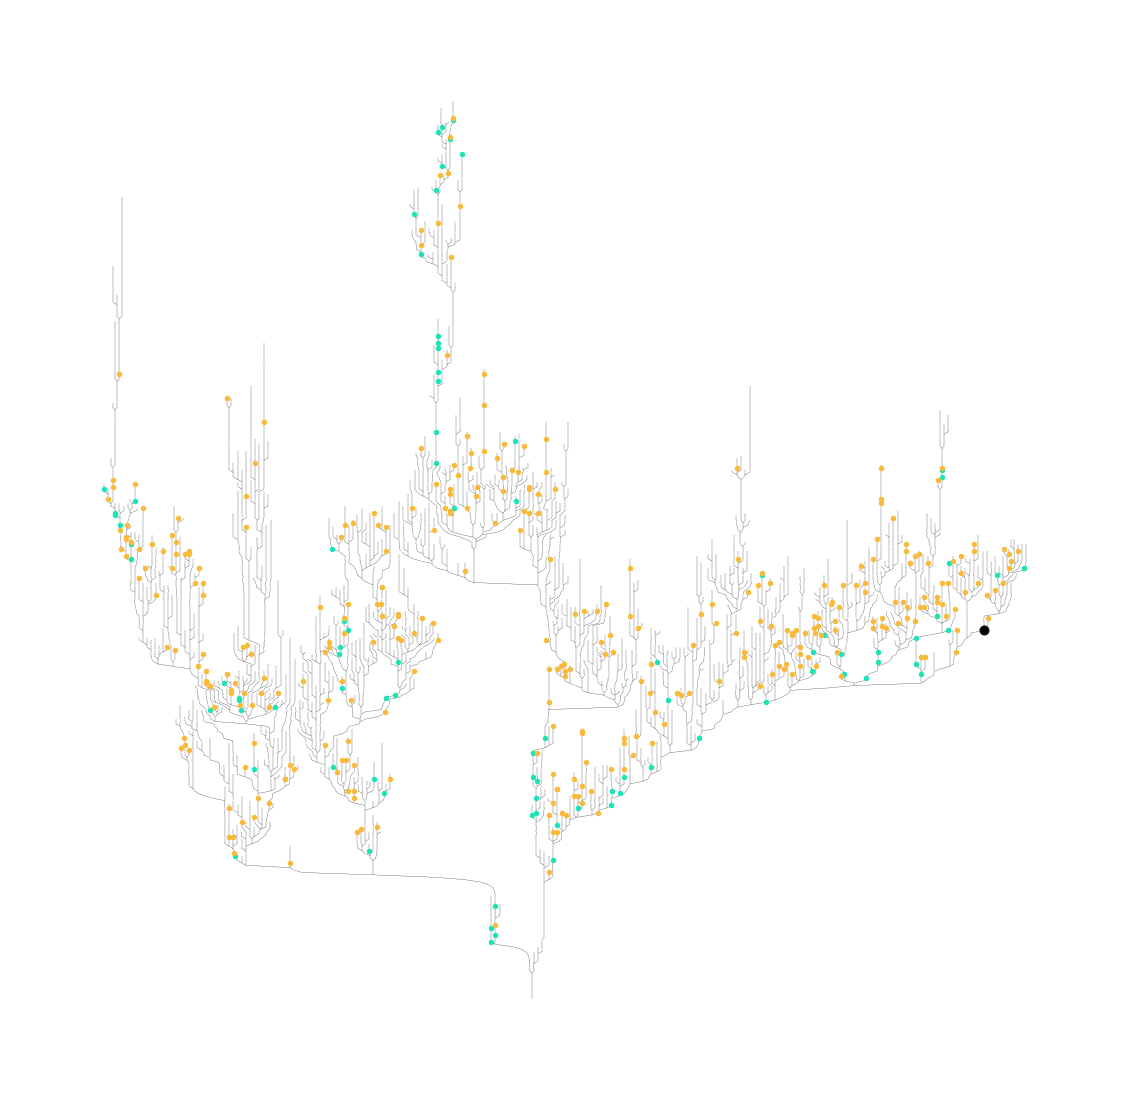

In [216]:
plt.clf()

fig, ax = plt.subplots(figsize = (20,20))

nbd.plot_dendrogram_from_graph(g, pos, navis_n_prep, highlight_connectors=connector_to_color)

plt.show()

In [217]:
# creating legend


legend_elements = []

for i in range(0, len(coloured_types)):
    
    
    legend_elements.append(Line2D([i], [0], marker = 'o', 
                                  color = type_to_col[coloured_types[i]],
                                  label = coloured_types[i], 
                                  markerfacecolor = type_to_col[coloured_types[i]],
                                  markersize = 60
                                 ))


<Figure size 432x288 with 0 Axes>

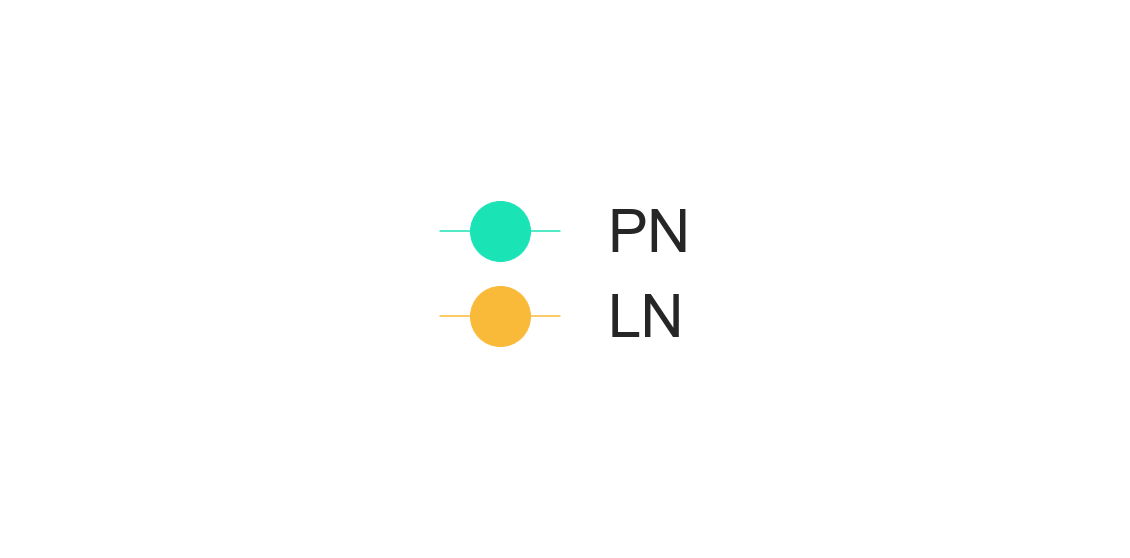

In [218]:
plt.clf()
fig, ax = plt.subplots(figsize = (20,10))

ax.legend(handles = legend_elements, loc= 'center', prop={'size':60})
plt.axis('off')
plt.show()
# plt.savefig(os.getcwd() + '/legend.png', dpi = 100)

# Number of branch points for OSNs

* How many branching points do the different neuron types  have on average (for example all OSNs; without 'not a branch' tagged branches)?

In [219]:
osn_df = pd.read_excel('osn_skid.xlsx')
osn_df.head()

,DA2 OSNs Skeleton Id,DL5 OSNs Skeleton Id
0,21783.0,244762
1,25146.0,113539
2,48162.0,132035
3,82695.0,134760
4,73054.0,134815


In [220]:
server = "https://catmaid.ice.mpg.de/catmaid_2020.02.15/#"
http_user = 'fly'
http_pw = 'superfly'
project_id = 2

def connect_adult_em():
    return pymaid.CatmaidInstance( server, token, http_user, http_pw, project_id = project_id)

connect_adult_em()

INFO  : Global CATMAID instance set. Caching is ON. (pymaid)


CatmaidInstance at 140512974365584.
Server: https://catmaid.ice.mpg.de/catmaid_2020.02.15/#
Project: 2
Caching True (size limit 128; time limit None)
Cache size: 0.0

In [221]:
da2_skids = osn_df.iloc[:,0].values[~np.isnan(osn_df.iloc[:,0].values)].astype(int)
da2_neurons = pymaid.get_neurons(da2_skids)

da2_node_dict = {j : dict(Counter(da2_neurons[i].nodes.type).most_common()) for i, j in enumerate(da2_skids)}
#da2_node_dict

da2_bp = [da2_node_dict[i]['branch'] for i in da2_skids]

Fetch neurons:   0%|          | 0/44 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/44 [00:00<?, ?it/s]

In [222]:
da2_pre_con_details = pymaid.get_connector_details(da2_neurons.presynapses.connector_id)
da2_pre_con_details.head()

CN details:   0%|          | 0/1069 [00:00<?, ?it/s]

INFO  : Data for 1069 of 1069 unique connector IDs retrieved (pymaid)


,connector_id,presynaptic_to,postsynaptic_to,presynaptic_to_node,postsynaptic_to_node
0,7413,94347,"[2245, 53093, 357381, 357381, 357381]",90468,"[7414, 7419, 7420, 95691, 95697]"
1,7728,21005,"[2245, 50080, 74856, 16964, 299511, 279378]",29098,"[7730, 7731, 7733, 7729, 7735, 286216]"
2,7751,52419,"[76977, 81524, 2245, 26898, 228627, 357381, 30...",71113,"[7755, 7757, 7758, 33702, 81929, 81908, 308951..."
3,7764,82413,"[23752, 2245, 49383, 49719, 21319, 44235, 4938...",82129,"[7768, 7185, 49313, 49314, 89682, 7767, 92869,..."
4,8152,52419,"[2245, 16964, 103653, 77074, 16964, 38640, 335...",70592,"[8154, 26211, 47052, 47343, 47341, 74575, 8189..."


In [223]:
da2_osn_DS_skids = np.unique(list(chain.from_iterable(da2_pre_con_details.postsynaptic_to)))
da2_osn_DS_neurons = pymaid.get_neurons(da2_osn_DS_skids)

Fetch neurons:   0%|          | 0/801 [00:00<?, ?it/s]

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


Make nrn:   0%|          | 0/801 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

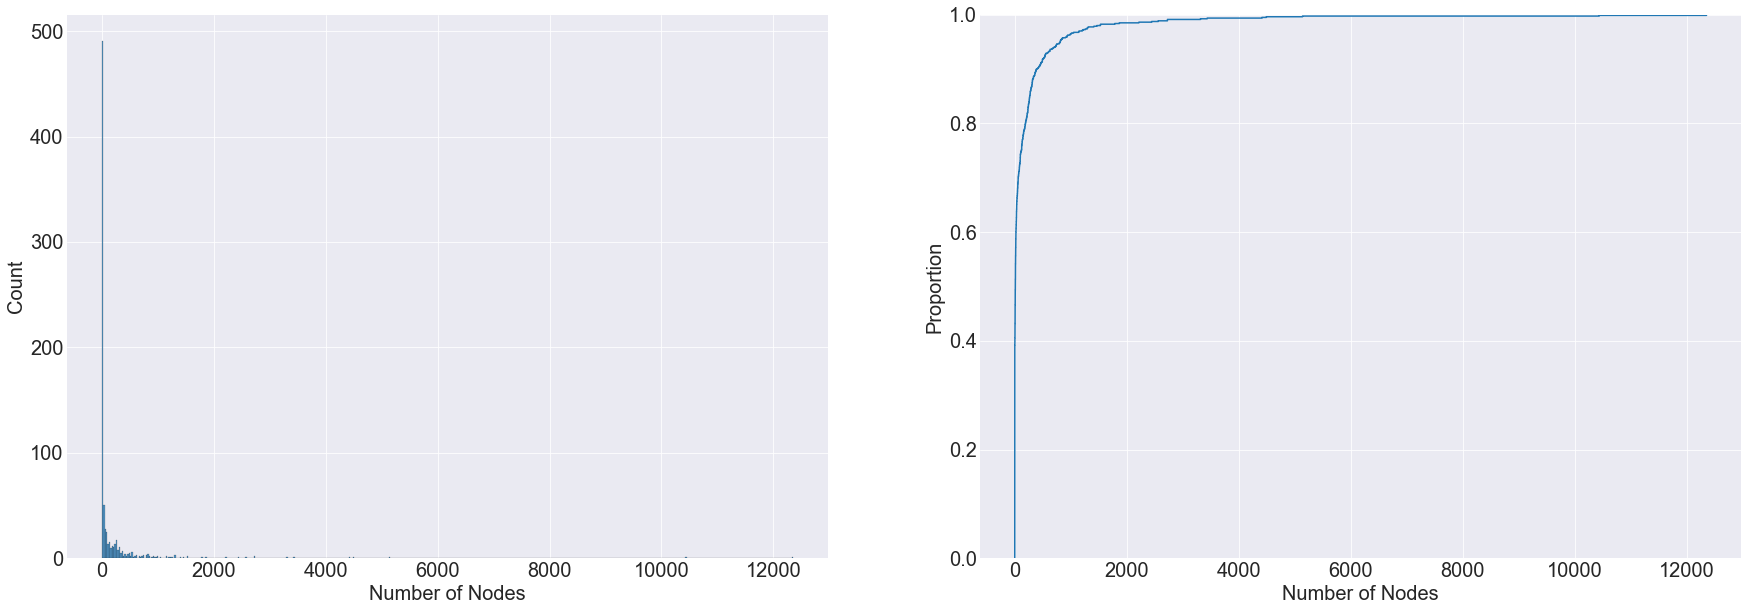

In [224]:
# There are a lot of partners that are only one node - remove those with less than 100 nodes
plt.clf()

fig = plt.figure(figsize = (30,10))
ax1 = fig.add_subplot(121)
sns.histplot(da2_osn_DS_neurons.n_nodes, ax = ax1)

plt.xlabel('Number of Nodes', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

ax2 = fig.add_subplot(122)
sns.ecdfplot(da2_osn_DS_neurons.n_nodes, ax = ax2)

plt.xlabel('Number of Nodes', fontsize = 20)
plt.ylabel('Proportion', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.show()

In [225]:
da2_partner_non_frag = pymaid.CatmaidNeuronList([i for i in da2_osn_DS_neurons if i.n_nodes > 100])
da2_partner_non_frag

,type,name,skeleton_id,n_nodes,n_connectors,n_branches,n_leafs,cable_length,soma,units
0,CatmaidNeuron,OSN#28,1681,266,49,11,12,64917.636719,None,1 nanometer
1,CatmaidNeuron,MGN#22,2245,936,160,85,88,166150.437500,None,1 nanometer
...,...,...,...,...,...,...,...,...,...,...
207,CatmaidNeuron,MGN#82,368029,315,48,25,26,56843.625000,None,1 nanometer
208,CatmaidNeuron,MGN#29,368140,986,141,65,68,137970.281250,None,1 nanometer


In [226]:
t = []

for i in da2_pre_con_details.postsynaptic_to: 
    
    p = []
    
    for j in i:
        
        if np.isin(j, da2_partner_non_frag.skeleton_id):
            
            p.append(j)
            
        else:
            
            continue
            
    t.append(np.unique(p))

In [227]:
da2_polyad_dict = dict(sorted(Counter([len(i) for i in t]).most_common()))

In [228]:
# da2_polyad_dict = dict(sorted(Counter([len(np.unique(i)) for i in da2_pre_con_details.postsynaptic_to]).most_common()))

* changing project for DL5

In [229]:
# Set CATMAID Instance
server = "https://catmaid.ice.mpg.de/catmaid_2020.02.15/#"
http_user = 'fly'
http_pw = 'superfly'
project_id = 6
# def connect_adult_em():
#     return pymaid.CatmaidInstance( server, http_user, http_pw, token)

def connect_adult_em():
    return pymaid.CatmaidInstance( server, token, http_user, http_pw, project_id = project_id)

connect_adult_em()

INFO  : Global CATMAID instance set. Caching is ON. (pymaid)


CatmaidInstance at 140513264504528.
Server: https://catmaid.ice.mpg.de/catmaid_2020.02.15/#
Project: 6
Caching True (size limit 128; time limit None)
Cache size: 0.0

In [230]:
dl5_skids = osn_df.iloc[:,1].values[~np.isnan(osn_df.iloc[:,1].values)].astype(int)
dl5_neurons = pymaid.get_neurons(dl5_skids)

dl5_node_dict = {j : dict(Counter(dl5_neurons[i].nodes.type).most_common()) for i, j in enumerate(dl5_skids)}
#dl5_node_dict

dl5_bp = [dl5_node_dict[i]['branch'] for i in dl5_skids]

Fetch neurons:   0%|          | 0/46 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/46 [00:00<?, ?it/s]

In [231]:
dl5_pre_con_details = pymaid.get_connector_details(dl5_neurons.presynapses.connector_id)
dl5_pre_con_details.head()

CN details:   0%|          | 0/1216 [00:00<?, ?it/s]

INFO  : Data for 1216 of 1216 unique connector IDs retrieved (pymaid)


,connector_id,presynaptic_to,postsynaptic_to,presynaptic_to_node,postsynaptic_to_node
0,67354,126961,"[278189, 249283, 355706, 188300, 188300, 18535...",122945,"[67355, 67357, 67351, 288241, 165332, 67358, 1..."
1,67550,112162,"[167153, 160172, 355706, 355706, 355706, 12109...",107319,"[67552, 67557, 67549, 67551, 67553, 117860, 24..."
2,67597,126961,"[138427, 250426, 355706, 222011]",122940,"[67598, 67599, 67514, 67600]"
3,67799,129577,"[69772, 355706, 69772, 250426, 250426, 355706,...",121085,"[67798, 156131, 121579, 121583, 121580, 121581..."
4,83559,113830,"[151172, 126961, 355706]",108364,"[112047, 120167, 83560]"


In [232]:
dl5_osn_DS_skids = np.unique(list(chain.from_iterable(dl5_pre_con_details.postsynaptic_to)))
dl5_osn_DS_neurons = pymaid.get_neurons(dl5_osn_DS_skids)

Fetch neurons:   0%|          | 0/769 [00:00<?, ?it/s]

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


Make nrn:   0%|          | 0/769 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

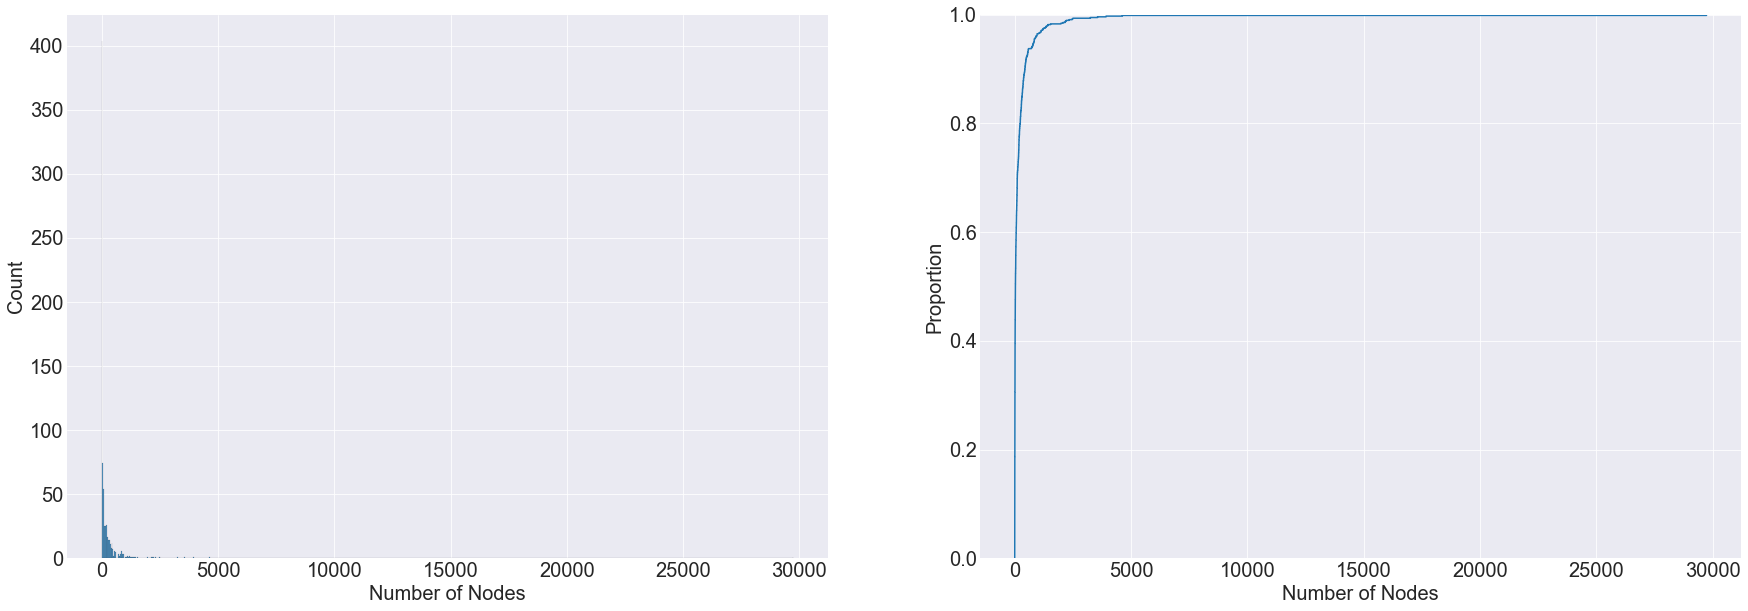

In [233]:
# There are a lot of partners that are only one node - remove those with less than 100 nodes
plt.clf()

fig = plt.figure(figsize = (30,10))
ax1 = fig.add_subplot(121)
sns.histplot(dl5_osn_DS_neurons.n_nodes, ax = ax1)

plt.xlabel('Number of Nodes', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

ax2 = fig.add_subplot(122)
sns.ecdfplot(dl5_osn_DS_neurons.n_nodes, ax = ax2)

plt.xlabel('Number of Nodes', fontsize = 20)
plt.ylabel('Proportion', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.show()

In [234]:
dl5_partner_non_frag = pymaid.CatmaidNeuronList([i for i in dl5_osn_DS_neurons if i.n_nodes > 100])
dl5_partner_non_frag

,type,name,skeleton_id,n_nodes,n_connectors,n_branches,n_leafs,cable_length,soma,units
0,CatmaidNeuron,MGN#56,69772,575,54,31,32,97032.304688,None,1 nanometer
1,CatmaidNeuron,MGN#97,69801,337,56,36,37,54825.058594,None,1 nanometer
...,...,...,...,...,...,...,...,...,...,...
250,CatmaidNeuron,MGN#53,366070,844,43,37,39,101510.773438,None,1 nanometer
251,CatmaidNeuron,Neuron 368503,368502,155,14,9,11,18870.500000,None,1 nanometer


In [235]:
t = []

for i in dl5_pre_con_details.postsynaptic_to: 
    
    p = []
    
    for j in i:
        
        if np.isin(j, dl5_partner_non_frag.skeleton_id):
            
            p.append(j)
            
        else:
            
            continue
            
    t.append(np.unique(p))

In [236]:
dl5_polyad_dict = dict(sorted(Counter([len(i) for i in t]).most_common()))

In [237]:
# dl5_polyad_dict = dict(sorted(Counter([len(np.unique(i)) for i in dl5_pre_con_details.postsynaptic_to]).most_common()))

### Creating boxplot and stripplot to visualise the number of branch points across o=OSN types 

In [238]:
da2 = ['DA2'] * len(da2_skids)
dl5 = ['DL5'] * len(dl5_skids)
pn = da2 + dl5
skids = np.append(da2_skids, dl5_skids)
nbp = da2_bp + dl5_bp

new_osn_df = pd.DataFrame()
new_osn_df['OSN'] = pn
new_osn_df['SKID'] = skids
new_osn_df['NBP'] = nbp
new_osn_df.head()

,OSN,SKID,NBP
0,DA2,21783,17
1,DA2,25146,17
2,DA2,48162,9
3,DA2,82695,11
4,DA2,73054,9


<Figure size 432x288 with 0 Axes>

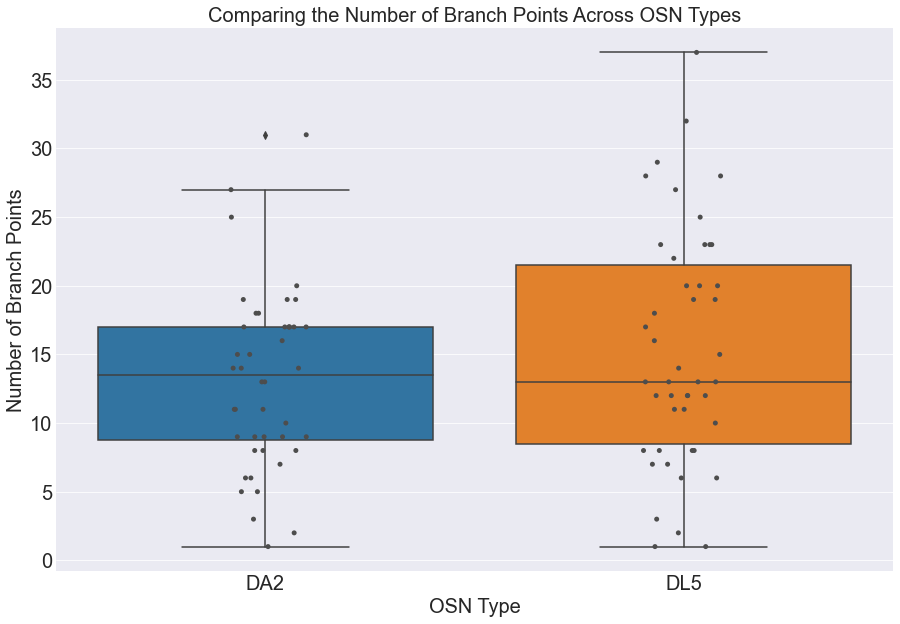

In [239]:
plt.clf()

fig, ax = plt.subplots(figsize = (15,10))

sns.boxplot(x = 'OSN', y = 'NBP', data = new_osn_df)
sns.stripplot(x="OSN", y="NBP", data=new_osn_df, color=".3")

plt.ylabel('Number of Branch Points', fontsize = 20)
plt.xlabel('OSN Type', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Comparing the Number of Branch Points Across OSN Types', fontsize = 20)

plt.show()

* what proportion of nodes are branch points?

In [240]:
total_nodes = np.append(da2_neurons.n_nodes, dl5_neurons.n_nodes)
# total_nodes

prop_nodes_branch = (nbp / total_nodes)
# prop_nodes_branch

new_osn_df['prop_NBP'] = prop_nodes_branch
new_osn_df

,OSN,SKID,NBP,prop_NBP
0,DA2,21783,17,0.061818
1,DA2,25146,17,0.052308
2,DA2,48162,9,0.039301
3,DA2,82695,11,0.041045
4,DA2,73054,9,0.060811
...,...,...,...,...
85,DL5,112025,16,0.042105
86,DL5,111993,12,0.041667
87,DL5,220510,13,0.064356
88,DL5,244670,1,0.016949


<Figure size 432x288 with 0 Axes>

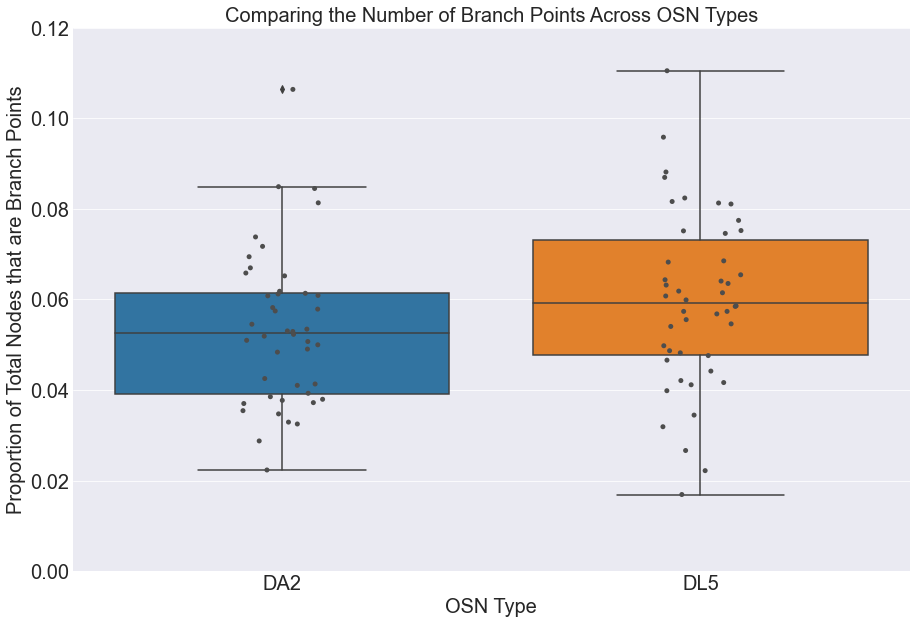

In [241]:
plt.clf()

fig, ax = plt.subplots(figsize = (15,10))

ax.set_ylim(bottom = 0.0, top = 0.12)

sns.boxplot(x = 'OSN', y = 'prop_NBP', data = new_osn_df)
sns.stripplot(x="OSN", y='prop_NBP', data=new_osn_df, color=".3")

plt.ylabel('Proportion of Total Nodes that are Branch Points', fontsize = 20)
plt.xlabel('OSN Type', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Comparing the Number of Branch Points Across OSN Types', fontsize = 20)

plt.show()

* What is the range of poliadicity (divergence of each presynapse/ T-bar) of each OSN?

1. take presynapses of each OSN
1. find out how many unique partners each presynapse connects to

In [242]:
polyad_df = pd.DataFrame(index = [i for i in range(max(da2_polyad_dict.keys()) + 1)])
# polyad_df

In [243]:
da2_polyad = []

for i in polyad_df.index: 
    
    try:
        #print(da2_polyad_dict[i])
        
        da2_polyad.append(da2_polyad_dict[i])
        
    except KeyError:
        
        #print(0)
        
        da2_polyad.append(0)

In [244]:
dl5_polyad = []

for i in polyad_df.index: 
    
    try:
        
        #print(dl5_polyad_dict[i])
        
        dl5_polyad.append(dl5_polyad_dict[i])
        
    except KeyError:
        
        #print(0)
        
        dl5_polyad.append(0)

In [245]:
polyad_df['DA2'] = da2_polyad
polyad_df['DL5'] = dl5_polyad
polyad_df.index.name = 'Number of Unique Downstream partners per presynapse'
polyad_df

,DA2,DL5
Number of Unique Downstream partners per presynapse,,
0,5,9
1,22,76
2,83,232
3,190,330
4,240,221
5,177,126
6,157,105
7,100,55
8,42,30


<Figure size 432x288 with 0 Axes>

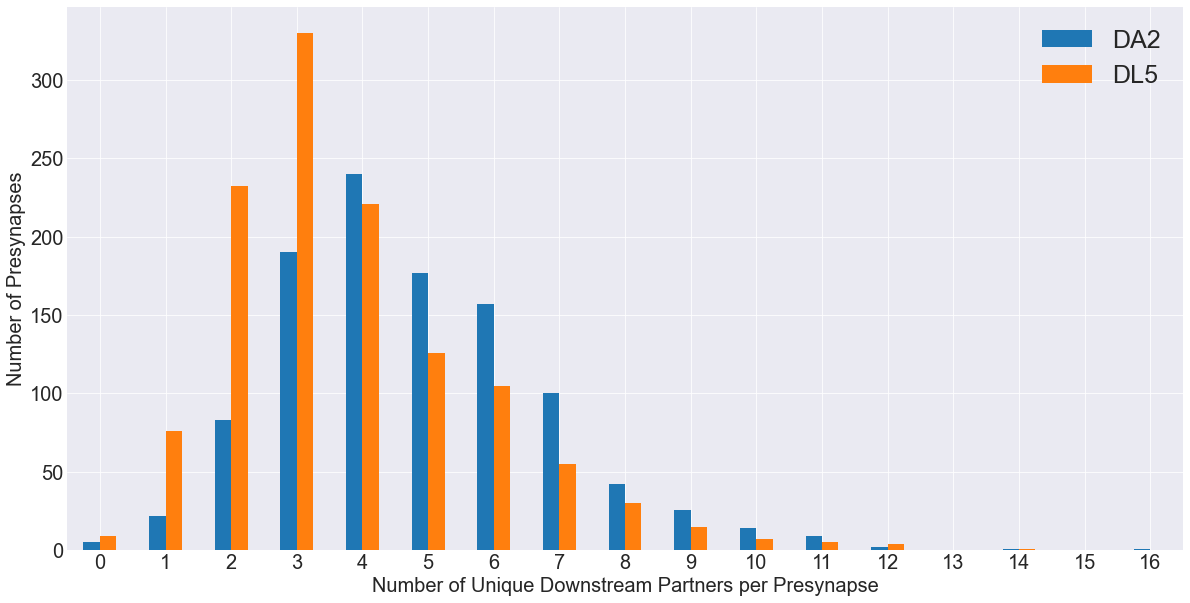

In [246]:
plt.clf()

fig, ax = plt.subplots(figsize = (20,10))
polyad_df.plot.bar(ax = ax)

plt.ylabel('Number of Presynapses', fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('Number of Unique Downstream Partners per Presynapse', fontsize = 20)
plt.xticks(fontsize = 20, rotation = 0)

plt.legend(prop = {'size' : 25})

plt.show()

In [247]:
polyad_df_norm = polyad_df.copy()
polyad_df_norm['DA2'] = (polyad_df.DA2 / polyad_df.DA2.sum())
polyad_df_norm['DL5'] = (polyad_df.DL5 / polyad_df.DL5.sum())
polyad_df_norm.head()

,DA2,DL5
Number of Unique Downstream partners per presynapse,,
0,0.004677,0.007401
1,0.020580,0.062500
2,0.077643,0.190789
3,0.177736,0.271382
4,0.224509,0.181743


<Figure size 432x288 with 0 Axes>

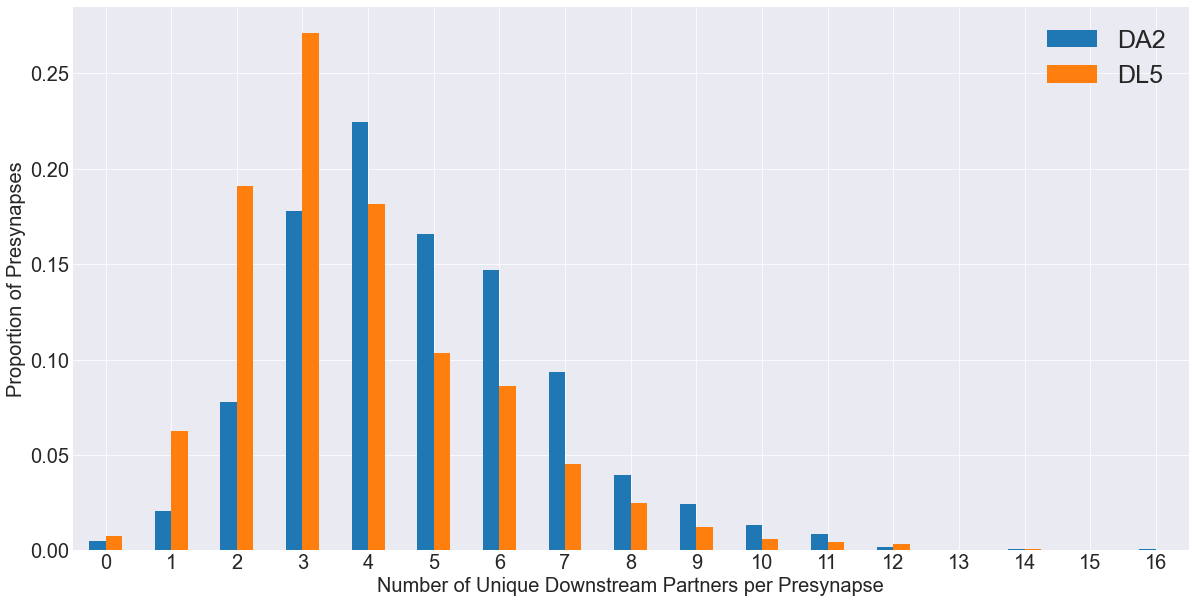

In [248]:
plt.clf()

fig, ax = plt.subplots(figsize = (20,10))
polyad_df_norm.plot.bar(ax = ax)

plt.ylabel('Proportion of Presynapses', fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('Number of Unique Downstream Partners per Presynapse', fontsize = 20)
plt.xticks(fontsize = 20, rotation = 0)

plt.legend(prop = {'size' : 25})

plt.show()

#### Synapse proportion at each strahler level